### imports

In [12]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, precision_score, accuracy_score, recall_score, confusion_matrix
from sklearn.experimental import enable_iterative_imputer,  enable_hist_gradient_boosting
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR
from xgboost import XGBRegressor   


import warnings
warnings.filterwarnings("ignore")

c:\Users\ckcho\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


<hr style="border: 2px solid #95e89e">

### I. filtering data to selected observation (top 20%)

#### what happens in these next 2 blocks of codes:

- importing datasets
- limiting the store dataset, `Rossmann_store.csv` to just the top 20% of stores in terms of sales
    - done by: calc avg sales for each store, then take top 20% of stores in terms of sales
- similarly, we wanna limit the other dataset we will use, `Rossmann_train.csv` so that it only gives us details of the top 20% sales stores
    - done by: filtering by the Store IDs based on those present in our t20 store df obtained earlier


In [3]:
import os
print(os.getcwd())  # Prints the current working directory


c:\Users\ckcho\OneDrive\Desktop\ADS Y2S1 2024\ADS1002 Data Challenges 2\Rossmann_git_public\Rossmann_Store_Sales_Forecasting\Previous version


In [7]:
import os

file_path = r"c:\Users\ckcho\OneDrive\Desktop\ADS Y2S1 2024\ADS1002 Data Challenges 2\Rossmann_git_public\Rossmann_Store_Sales_Forecasting\Rossmann_store.csv"

print("File exists:", os.path.exists(file_path))


File exists: False


In [11]:
rossmann_store = pd.read_csv("../data/Rossmann_store.csv")
rossmann_sales = pd.read_csv("../data/Rossmann_train.csv")

In [4]:
# creating a function to calculate the average sales for a store
def calc_avg_sales(store_id: int)-> float:
    """This function takes a store ID and returns the average sales value for that store."""
    a_store = rossmann_sales.loc[ (rossmann_sales['Store'] == store_id) ]
    avg_sales = a_store['Sales'].mean()
    return avg_sales.round(2)

# calculating and recording the average sales for each store
store_avg_sales = []
for i in range(1,1116):
    store_avg_sales.append(calc_avg_sales(i))

# adding the average sales data for each store into the store dataset
rossmann_store_w_avg = pd.concat([rossmann_store, pd.DataFrame({'AverageSales' : store_avg_sales})], axis=1)

# taking the top 20 percent of stores in terms of sales
rossmann_store_t20 = \
rossmann_store_w_avg.loc[ (rossmann_store_w_avg['AverageSales'] >= rossmann_store_w_avg['AverageSales'].quantile(0.8)) ]

# filtering the sales dataset
rossmann_sales_t20 = rossmann_sales.loc[ rossmann_sales['Store'].isin(rossmann_store_t20['Store']) ]

<hr style="border: 2px solid #73deb0">

### II. merging datasets & imputation of missing values for Promo2-related columns

#### what happens in this next block of code (done with method chaining):
- merged datasets
- convert `Date` dtype to datetime
- to reduce confusion, renamed `PromoInterval` to `Promo2Interval` since it's referring to Promo2

- filled in missing values for `Promo2SinceWeek`, `Promo2SinceYear`, and `Promo2Interval`
    - `Promo2SinceWeek`, `Promo2SinceYear` : replaced NaN with <b>0</b> if `Promo2` == 0
    - `Promo2Interval` : replaced NaN with <b>NA</b> (= Not Applicable) if `Promo2` == 0

- created a new column with category codes: `Promo2IntervalCat`
    - category <b>0</b> is <b>NA</b>
    - category <b>1</b> is <b>Jan,Apr,Jul,Oct</b>
    - category <b>2</b> is <b>Feb,May,Aug,Nov</b>
    - category <b>3</b> is <b>Mar,Jun,Sept,Dec</b>


In [5]:
rossmann = (
    pd.merge(rossmann_store_t20, rossmann_sales_t20, on='Store', how='right')   # merging the filtered datasets
    .assign(Date = lambda df: pd.to_datetime(df['Date']))                       # converting Date dtype from to datetime
    .rename(columns={'PromoInterval':'Promo2Interval'})                         # renaming PromoInterval to Promo2Interval
    
    # filling in some missing values based on original data 
    .fillna({'Promo2SinceWeek':0,'Promo2SinceYear':0,'Promo2Interval':'NA'})
    
    # converting certain variables to more suitable data types
    .astype({'Promo2SinceWeek':'int64','Promo2SinceYear':'int64','Sales':'float64'})
    
    # creating a new column to categorize Promo2Interval
    .assign(Promo2IntervalCat = lambda df: df['Promo2Interval']
            .astype('category')
           )
    # changing categories to categorical codes for the new column
    .assign(Promo2IntervalCat = lambda df: pd.Categorical(df['Promo2IntervalCat'], categories= \
                                                          ['NA','Jan,Apr,Jul,Oct','Feb,May,Aug,Nov','Mar,Jun,Sept,Dec'])
            .codes
           )
    .set_index('Date')   # setting the Date as our index
    
    .drop(columns=['AverageSales']) # remove the column previously introduced to determine the T20 stores
)

In [6]:
rossmann.isna().sum()

Store                            0
StoreType                        0
Assortment                       0
CompetitionDistance              0
CompetitionOpenSinceMonth    57874
CompetitionOpenSinceYear     57874
Promo2                           0
Promo2SinceWeek                  0
Promo2SinceYear                  0
Promo2Interval                   0
DayOfWeek                        0
Sales                            0
Customers                        0
Open                             0
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
Promo2IntervalCat                0
dtype: int64

* We observe missing values only exists in `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear` columns.

<hr style="border: 2px solid #73deb0">

### III. Imputation for further missing data

Unlike `Promo2`-related columns, the null values in `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear` cannot be deduced from observing the original data alone. Thus, we attempt to fill in these values with a suitable imputation method.

#### What happens in this next block of code:
- Note that `pipe` method is used as there are multiple data processing functions to call for readability and clarity of code.<br><br>

- **Preliminary Analysis** 
    - setting up **k-Nearest Neighbours** model to observe test scores for different imputation methods
    - test scores includes `accuracy`, `precision` and `recall`.
    - Investigate the most suitable k value to be used in the KNN model using the `elbow method`
<br>

- **Simple imputation**
    - **Mean** and **Median** imputation is used
    - **Testing scores** are computed
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **KNN imputation**
    - try `KNeighborsRegressor` using normalized data
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Linear Regression Imputation**
    - Plot `heatmap` to investigate correlation between variables
    - Use the `IterativeImputer` to impute missing data between the imputation columns and columns with the highest correlation with imputation columns
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Forest Imputation**
    - Use the combination fo `IterativeImputer` and `RandomForestRegressor` to impute missing values.
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Imputation Conclusion**
    - Concluding imputation findings.
    - Choose the best way of imputation

<hr>


#### **Preliminary Analysis**

* Setting up **k-Nearest Neighbours model**

In [7]:
def kNN_model(df,feature_columns, target, n):
    Xf = df[feature_columns]
    Yf = df[[target]]
    
    X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=0)
    kNN = KNeighborsClassifier(n_neighbors=n)
    kNN.fit(X_train, Y_train.values.ravel())  # fit the data to the model
    Y_pred = kNN.predict(X_test)  # Predict the target values from the test feature data

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='binary' if len(Yf[target].unique()) == 2 else 'weighted')
    rec = recall_score(Y_test, Y_pred, average='binary' if len(Yf[target].unique()) == 2 else 'weighted')
    
    print("\n")
    print(f'Testing scores: accuracy {acc:.3f}, precision {prec:.3f}, recall {rec:.3f}')

* Find the n-neighbors for k-Nearest Neighbours using the elbow method

In [8]:
# keep first (may use later)

def elbow_method_knn(df, feature_columns, target, max_k=40, test_size=0.2, random_state=14):
    # Separate features and target
    Xf = df[feature_columns]
    Yf = df[target]

    # Ensure features and target are aligned
    Xf, Yf = Xf.align(Yf, join='inner', axis=0)
    
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=test_size, random_state=random_state)
    
    error_rate = []

    # Loop through different k values to find the optimal one
    for i in range(1, max_k):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred_i = knn.predict(X_test)
        # Calculate error rate as the proportion of misclassified samples
        error_rate.append(np.mean(pred_i != Y_test))
    
    # Plotting the Mean Absolute Deviation vs. Number of Neighbors
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_k), error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Mean Absolute Deviation vs. Number of Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Error Rate vs. K Value')
    plt.grid(True)
    plt.show()
    
    # Find the optimal number of neighbors
    k = np.argmin(error_rate) + 1
    return k

#optimal_k = elbow_method_knn(rossmann_mean_impute, feature_columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], target='Sales')
#print(f"Optimal number of neighbors for k-NN: {optimal_k}")


[[26  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  0]]


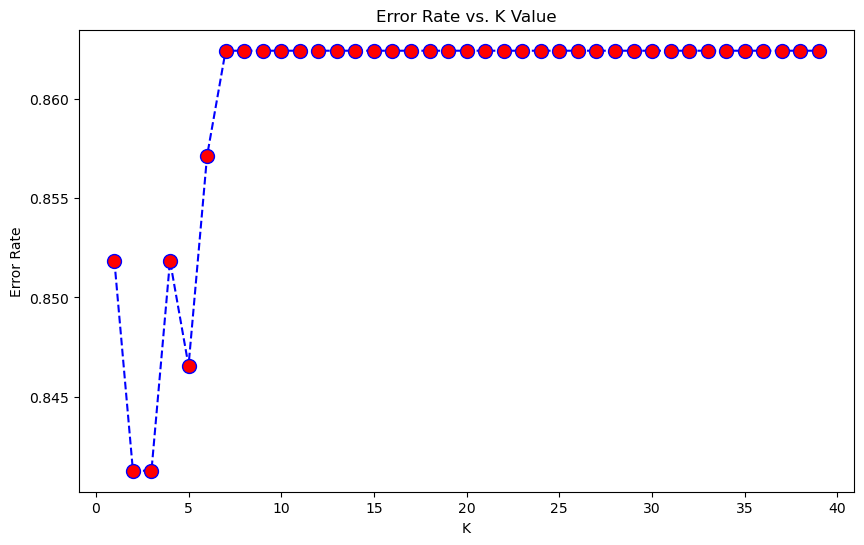

In [9]:
Xf = rossmann[rossmann.select_dtypes(['int','float']).columns.to_list()].dropna().drop_duplicates()
Yf = rossmann['Sales']

Xf = Xf.loc[~Xf.index.duplicated(keep='first')]
Yf = Yf.loc[~Yf.index.duplicated(keep='first')]

# Align Xf and Yf to ensure they have the same indices
Xf, Yf = Xf.align(Yf, join='inner', axis=0)
Xf, Yf = Xf.align(Yf, join='inner', axis=0)


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=13)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,Y_train)
pred = knn.predict(X_test)
print(confusion_matrix(Y_test,pred))


error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

* As shown in the error rate plot above, the optimal k value will be **k=1**

#### **Simple imputation**

##### Mean Inputation Functions

In [10]:
def impute_mean(df):
    df_mean = df.copy()
    df_mean.fillna(df_mean.mean(),inplace=True)
    return df_mean

    
rossmann_mean_impute = impute_mean(rossmann[rossmann.select_dtypes(['int','float']).columns.to_list()])


Print the testing scores out:

In [11]:
print("Imputation using mean")
kNN_model(rossmann_mean_impute,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)

Imputation using mean


Testing scores: accuracy 0.638, precision 0.680, recall 0.638


##### Median Inputation Functions

In [12]:
def impute_median(df):
    df_median = df.copy()
    df_median.fillna(df_median.median(),inplace=True)
    return df_median


rossmann_median_impute = impute_median(rossmann[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales']])

Print the testing scores out:

In [13]:
print("Imputation using median")
kNN_model(rossmann_median_impute,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)

Imputation using median


Testing scores: accuracy 0.640, precision 0.682, recall 0.640


##### Histogram plot 

* plot histogram to observe the appropriateness of imputation using mean and median

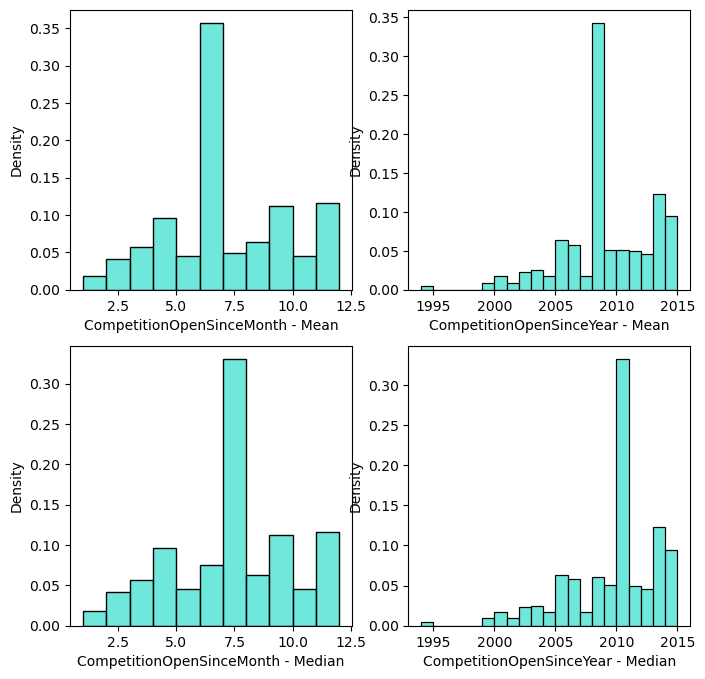

In [14]:
fig, axes = plt.subplots(2,2,figsize=(8, 8))

sns.histplot(rossmann_mean_impute, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0, 0])
axes[0, 0].set_xlabel('CompetitionOpenSinceMonth - Mean')

sns.histplot(rossmann_median_impute, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[1, 0])
axes[1, 0].set_xlabel('CompetitionOpenSinceMonth - Median')

sns.histplot(rossmann_mean_impute, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[0, 1])
axes[0, 1].set_xlabel('CompetitionOpenSinceYear - Mean')

sns.histplot(rossmann_median_impute, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1, 1])
axes[1, 1].set_xlabel('CompetitionOpenSinceYear - Median');

<hr>

**Observations**

- By observing the histogram, we observe a **peak** value which differs a lot with other values for both the **mean and median plot** <br>
- This indicates that mean and median imputation may not be a suitable way to impute the missing data in `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` column.

<hr>

#### **Knn imputation (Using KNeighborsRegressor)**

In [15]:
knn2 = rossmann.select_dtypes(include=['int', 'float']).copy()
filtered_rm = knn2.dropna(subset=['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'])

# Prepare data for training and testing
X = filtered_rm[['CompetitionDistance','Promo2']]
y_year = filtered_rm['CompetitionOpenSinceYear']
y_month = filtered_rm['CompetitionOpenSinceMonth']


X_train, X_test, y_train_year, y_test_year = train_test_split(X, y_year, test_size=0.2, random_state=1)
X_train, X_test, y_train_month, y_test_month = train_test_split(X, y_month, test_size=0.2, random_state=1)

# Train the k-NN models
knn_m_year = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_m_month = KNeighborsRegressor(n_neighbors=3, weights='distance')

model_year = knn_m_year.fit(X_train, y_train_year)
model_month = knn_m_month.fit(X_train, y_train_month)

# Find missing values
missing_year = knn2['CompetitionOpenSinceYear'].isnull()
missing_month = knn2['CompetitionOpenSinceMonth'].isnull()

df_missing_year = knn2[['CompetitionDistance','Promo2']][missing_year]
df_missing_month = knn2[['CompetitionDistance','Promo2']][missing_month]

# Predict and impute missing values
year_impute = model_year.predict(df_missing_year)
month_impute = model_month.predict(df_missing_month)

# Create another data set copy to prevent original DataFrame modification
rm_imputed = knn2.copy()

# Impute the predicted values 
rm_imputed.loc[missing_year, 'CompetitionOpenSinceYear'] = year_impute
rm_imputed.loc[missing_month, 'CompetitionOpenSinceMonth'] = month_impute

rossmann_cat = rossmann.select_dtypes(include=['int8', 'object']).copy()
rm_imputed = pd.concat([rm_imputed, rossmann_cat], axis=1)

# Evaluate model
'''
y_pred_test_year = model_year.predict(X_test)
mse_year = mean_squared_error(y_test_year, y_pred_test_year)
r2_year = r2_score(y_test_year, y_pred_test_year)


y_pred_test_month = model_month.predict(X_test)
mse_month = mean_squared_error(y_test_month, y_pred_test_month)
r2_month = r2_score(y_test_month, y_pred_test_month)

print('Year - Mean Squared Error:', mse_year)
print('Year - R^2 Score:', r2_year)
print('Month - Mean Squared Error:', mse_month)
print('Month - R^2 Score:', r2_month)

#rkm_imputed.isna().sum()'''

"\ny_pred_test_year = model_year.predict(X_test)\nmse_year = mean_squared_error(y_test_year, y_pred_test_year)\nr2_year = r2_score(y_test_year, y_pred_test_year)\n\n\ny_pred_test_month = model_month.predict(X_test)\nmse_month = mean_squared_error(y_test_month, y_pred_test_month)\nr2_month = r2_score(y_test_month, y_pred_test_month)\n\nprint('Year - Mean Squared Error:', mse_year)\nprint('Year - R^2 Score:', r2_year)\nprint('Month - Mean Squared Error:', mse_month)\nprint('Month - R^2 Score:', r2_month)\n\n#rkm_imputed.isna().sum()"

In [16]:
kNN_model(rm_imputed,['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.559, precision 0.601, recall 0.559


<hr>

* Plot historgram

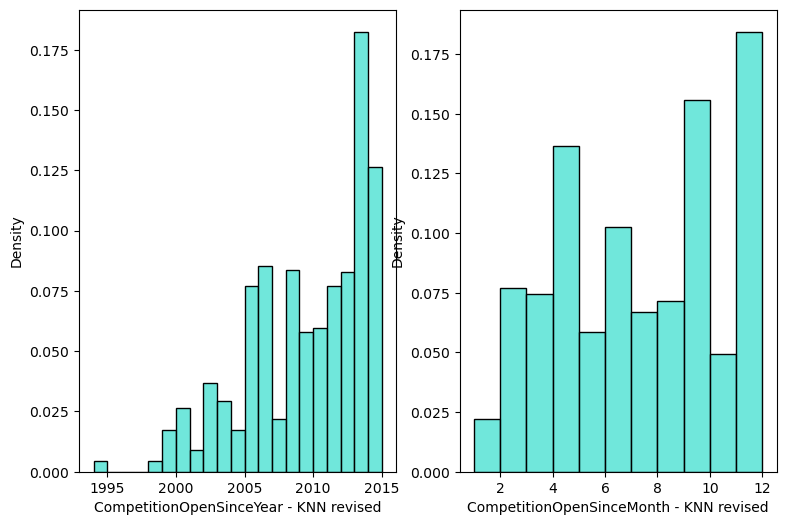

In [17]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(rm_imputed, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[0].set_xlabel('CompetitionOpenSinceYear - KNN revised')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(rm_imputed, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[1].set_xlabel('CompetitionOpenSinceMonth - KNN revised');

<hr>

**Observations:**

* `CompetitionOpenSinceYear` column
    * We observe a **bell shape curve** for inputation of `CompetitionOpenSinceYear` using the `KNN imputation` method.
    * This suggests that `KNN imputation` is most likely approriate to impute the missing values in `CompetitionOpenSinceYear`

* `CompetitionOpenSinceMonth` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.


<hr>

#### **Linear Regression Imputation**

##### Heat map

* To perform the linear regression imputation, we first have to investigate the feature columns that have the **highest correlation** with the columns that will be imputed.
* This will means that we are using `heatmap` to investigate the correlation between variables.

In [18]:
corr=rossmann.select_dtypes(include=['int','float']).corr()
corr.style.background_gradient(cmap='coolwarm')

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.000000,-0.020639,-0.048537,0.078079,-0.035265,0.015268,-0.035197,0.000013,0.002910,0.012172,0.000416,-0.000074,-0.001014
CompetitionDistance,-0.020639,1.000000,-0.118109,-0.055882,-0.013439,-0.007115,-0.013575,-0.000014,-0.088812,-0.190187,0.009070,0.000081,-0.006431
CompetitionOpenSinceMonth,-0.048537,-0.118109,1.000000,-0.021087,-0.108020,-0.193129,-0.107976,0.000023,-0.023131,-0.044904,0.003392,-0.000135,0.002586
CompetitionOpenSinceYear,0.078079,-0.055882,-0.021087,1.000000,-0.185836,-0.135143,-0.185775,-0.000064,0.008688,-0.024208,0.006310,0.000372,0.003223
Promo2,-0.035265,-0.013439,-0.108020,-0.185836,1.000000,0.816155,0.999999,0.000141,-0.085478,-0.144386,-0.016304,-0.000817,-0.007521
Promo2SinceWeek,0.015268,-0.007115,-0.193129,-0.135143,0.816155,1.000000,0.815936,0.000176,-0.049850,-0.083829,-0.012567,-0.001024,-0.007005
Promo2SinceYear,-0.035197,-0.013575,-0.107976,-0.185775,0.999999,0.815936,1.000000,0.000141,-0.085468,-0.144353,-0.016296,-0.000817,-0.007523
DayOfWeek,0.000013,-0.000014,0.000023,-0.000064,0.000141,0.000176,0.000141,1.000000,-0.492422,-0.368928,-0.513589,-0.392926,-0.206547
Sales,0.002910,-0.088812,-0.023131,0.008688,-0.085478,-0.049850,-0.085468,-0.492422,1.000000,0.860537,0.752449,0.478007,0.091250
Customers,0.012172,-0.190187,-0.044904,-0.024208,-0.144386,-0.083829,-0.144353,-0.368928,0.860537,1.000000,0.637923,0.301030,0.069432


* It seems like the two columns with missing values, `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` have a very weak correlation with all other variables in the data set.
* In this case, we choose the best possible variable, which is the `Promo2`.

##### Iterative Imputer (Linear Imputation)

* Next, we will use the `Iterative Imputer` to impute missing values in `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` columns.

In [19]:
#Prepare Data
rossmann_reg = rossmann.select_dtypes(include=['int', 'float']).copy()
feature_columns = ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2']
df_to_impute = rossmann_reg[feature_columns]

# Instantiate Iterative Imputer 
imputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)

#Fit and Transform Data 
imputed_data = imputer.fit_transform(df_to_impute)

# Impute
rossmann_reg[feature_columns] = imputed_data

#rossmann_reg.isna().sum()

In [20]:
kNN_model(rossmann_reg,['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.620, precision 0.663, recall 0.620


<hr>

* Plot histogram

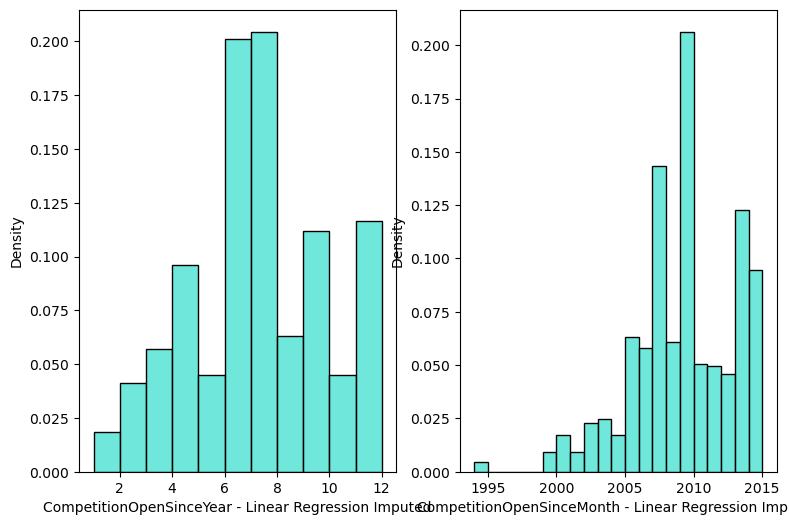

In [21]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(rossmann_reg, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[1].set_xlabel('CompetitionOpenSinceMonth - Linear Regression Imputed')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(rossmann_reg, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[0].set_xlabel('CompetitionOpenSinceYear - Linear Regression Imputed');

<hr>

**Observations:**

* `CompetitionOpenSinceYear` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.ionOpenSinceYear`

* `CompetitionOpenSinceMonth` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.


<hr>

#### **Forest Imputation**

In [22]:
rossmann_mice = rossmann[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales']].copy()
# Initialize Iterative Imputer with RandomForestRegressor
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, random_state=0), random_state=0)

# Fit and transform data 
imputed_data = imputer.fit_transform(rossmann_mice)

# Convert imputed data back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=rossmann_mice.columns)


In [23]:
kNN_model(imputed_df,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.650, precision 0.692, recall 0.650


<hr>

* Plot histogram

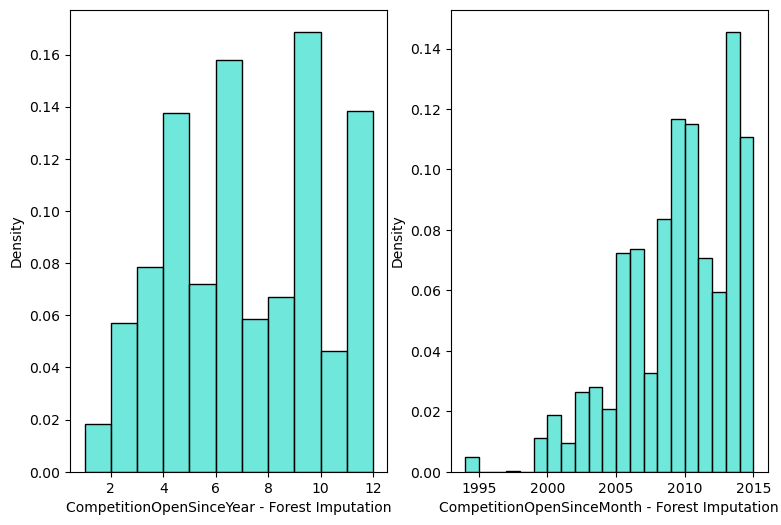

In [24]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(imputed_df, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[1].set_xlabel('CompetitionOpenSinceMonth - Forest Imputation')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(imputed_df, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[0].set_xlabel('CompetitionOpenSinceYear - Forest Imputation');

<hr>

**Observations:**

* We get almost the same histogram plot as in the KNN imputation method


<hr>

#### **Imputation conclusion**

* As observed in the `heatmap`, we found out that the columns with missing value, specifically `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` has a very weak correlation with other variables.
    * This suggests that these two feature variables has very minimal effect towards our target variable, the `Sales`.
* Hence, we will never get a perfect `bell shape` curve histogram for any of the imputation methods.

* The chosen imputation method is <u>KNN imputation</u>

<hr style="border: 2px solid #73deb0">

### IV. Time Series Analysis

In [25]:
rm_imputed.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StoreType,Assortment,Promo2Interval,StateHoliday,Promo2IntervalCat
Date,,,,,,,,,,,,,,,,,,
2015-07-31,4,620.0,9.0,2009.0,0,0,0,5,13995.0,1498,1,1,1,c,c,NA,0,0
2015-07-31,7,24000.0,4.0,2013.0,0,0,0,5,15344.0,1414,1,1,1,a,c,NA,0,0
2015-07-31,24,4590.0,3.0,2000.0,1,40,2011,5,14190.0,1082,1,1,1,a,c,"Jan,Apr,Jul,Oct",0,1
2015-07-31,25,430.0,4.0,2003.0,0,0,0,5,14180.0,1586,1,1,1,c,a,NA,0,0
2015-07-31,27,60.0,1.0,2005.0,1,5,2011,5,13213.0,1263,1,1,1,a,a,"Jan,Apr,Jul,Oct",0,1


Now, we can start data analysis.

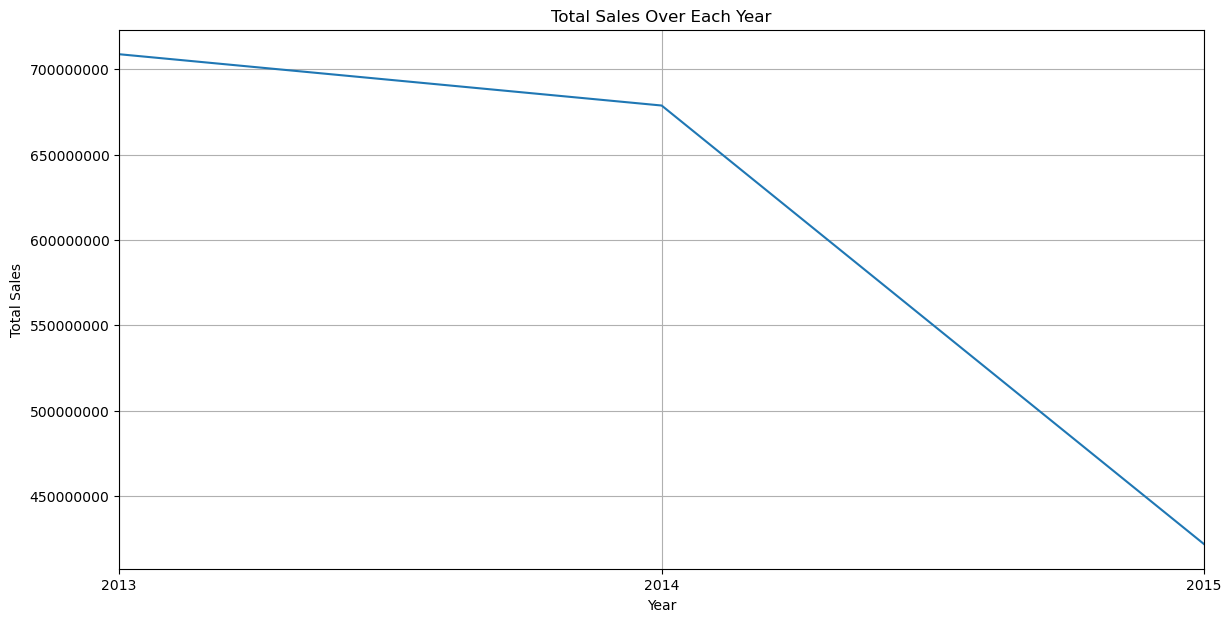

In [26]:
sales_year = rm_imputed['Sales'].resample('Y').sum()

# Plot the total sales over each year
plt.figure(figsize=(14, 7))
sales_year.plot.line()
plt.title('Total Sales Over Each Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.show()


From the above plot, we see that there is a clear decline in sales in the year 2014
<br>So let's see what the total sales pattern is like in each month:

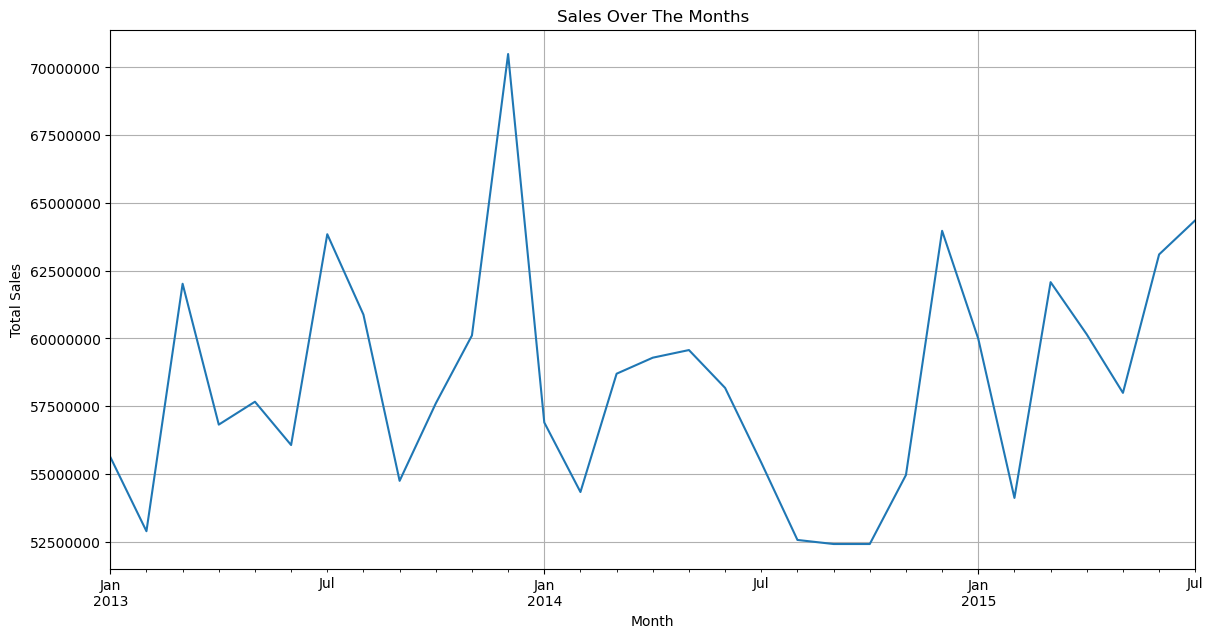

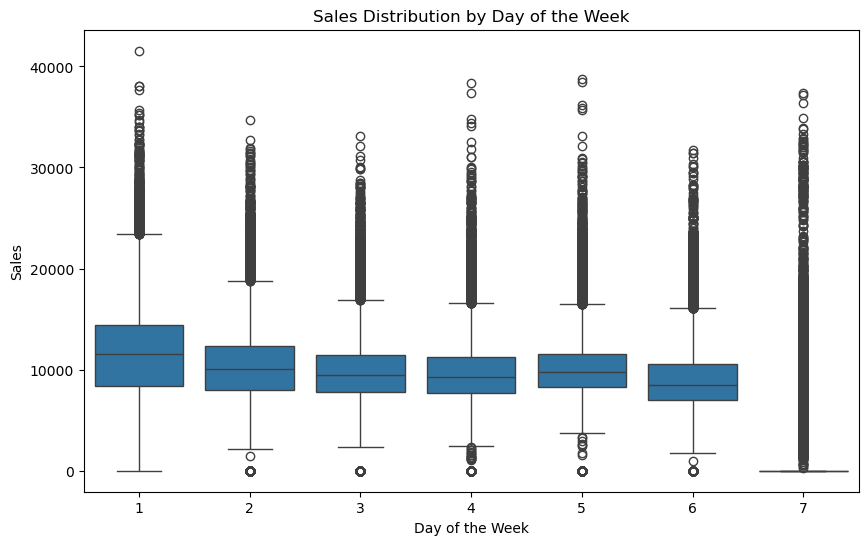

In [27]:
sales_monthly = rm_imputed['Sales'].resample('M').sum()

plt.figure(figsize=(14, 7))
sales_monthly.plot.line()
plt.title('Sales Over The Months')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='Sales', data=rossmann)
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()


There are a lot of fluctuations in sales throughout the years, but December 2013 has the highest peak in sales. However, there is a decline in sales from then onwards till October 2014. After which sales increase again in December 2014.

Additionally, the boxplot tells us the following points:
1) Monday (Day 1) has the highest median sales compared to the rest of the week. It also has a wider spread of sales values, as indicated by the length of the whiskers.
2) Saturday (Day 7) has the lowest median sales and the most extreme outliers, with several sales values far above the rest.
3) Tuesday to Friday (Days 2-6) have fairly consistent median sales and similar distributions. They all show a somewhat tight range of sales with a few outliers.
4) Outliers are present for each day, but they're especially noticeable on Monday and Saturday, suggesting that some stores or locations experience unusually high sales on these days.

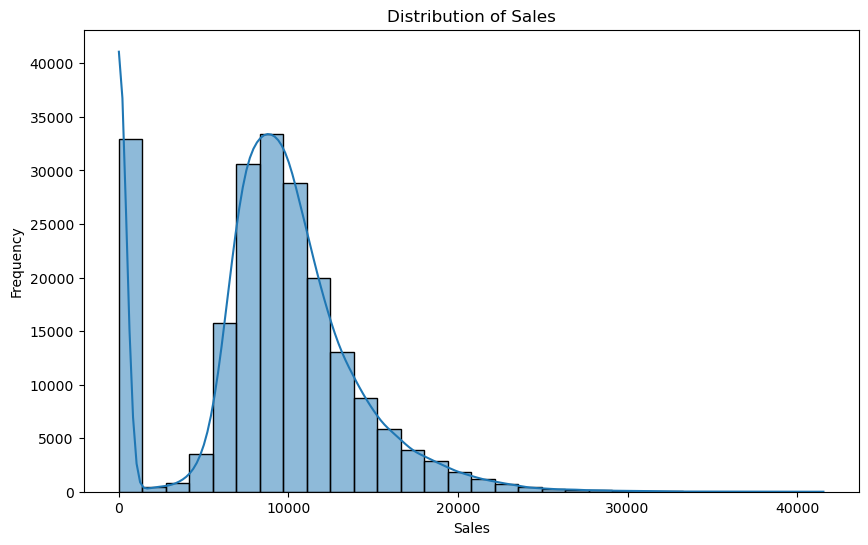

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(rm_imputed['Sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

Now let's look at the influence of promotion in sales

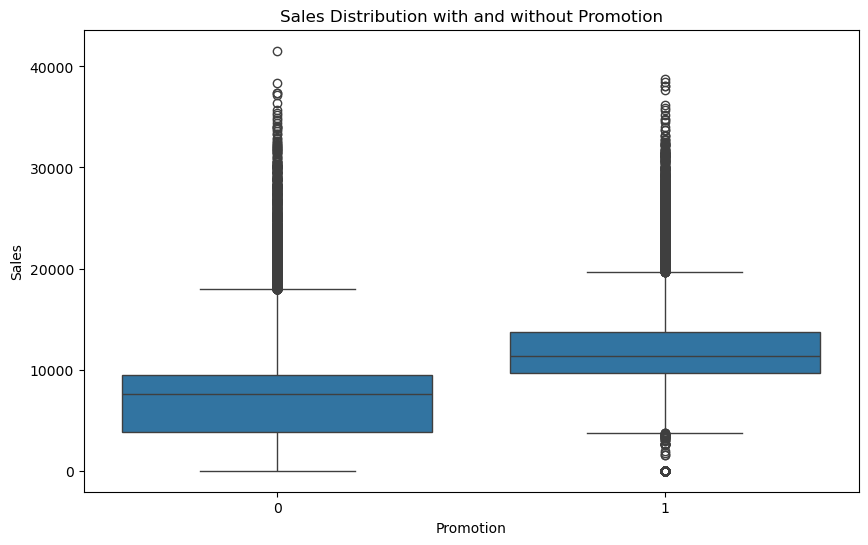

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promo', y='Sales', data=rm_imputed)
plt.title('Sales Distribution with and without Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.show()

From the above, it is clear that with promotion there is a slightly more increase in sales compared to without promotion

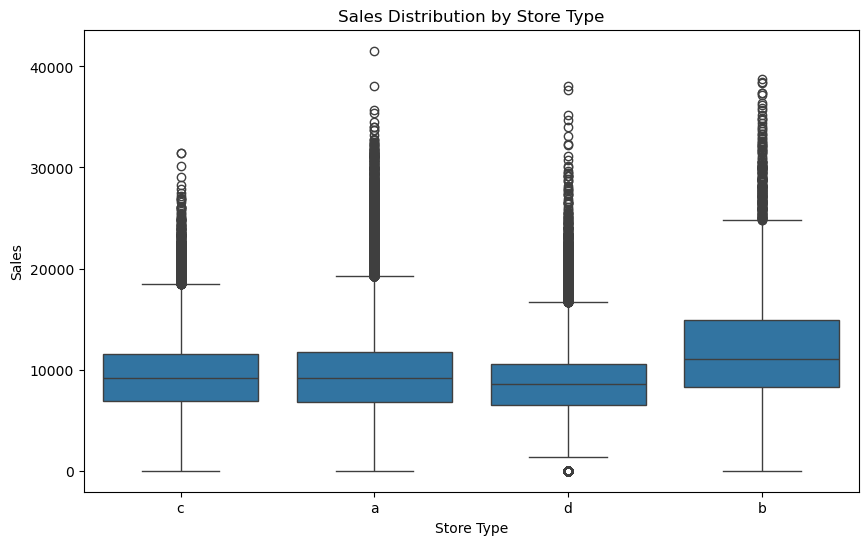

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='StoreType', y='Sales', data=rm_imputed)
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()


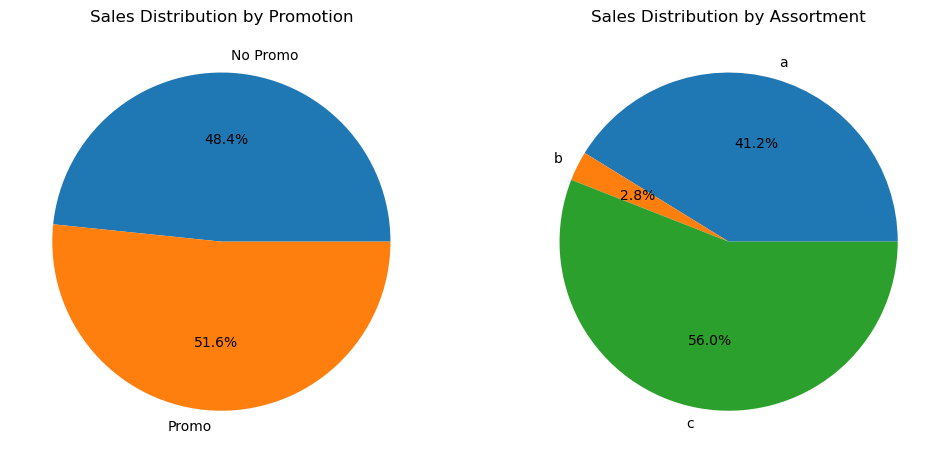

In [31]:
# tentatively keeping - lecturer said he don't like pie charts..??

fig, ax = plt.subplots(1,2,figsize=(12,6))

promo_sales = rm_imputed.groupby('Promo')['Sales'].sum()
ax[0].pie(promo_sales, labels=['No Promo', 'Promo'],autopct='%1.1f%%')
ax[0].set_title('Sales Distribution by Promotion');

assortment_sales = rm_imputed.groupby('Assortment')['Sales'].sum()
ax[1].pie(assortment_sales, labels=assortment_sales.index, autopct='%1.1f%%')
ax[1].set_title('Sales Distribution by Assortment');

<hr>

#### Some further time-series analysis (long-term patterns, promotions, store assortment)

To observe longer-term patterns, we will use rolling mean for the sales with a weekly window.

1. From the sales over months plot, we observe:
    - A sudden peak in 2013, December starting from November.
    - A dip in sales in 2014, August to October.
    - Relatively stable, moderate sales in 2014, May to March
    
Zooming into 2-month periods within these time periods:

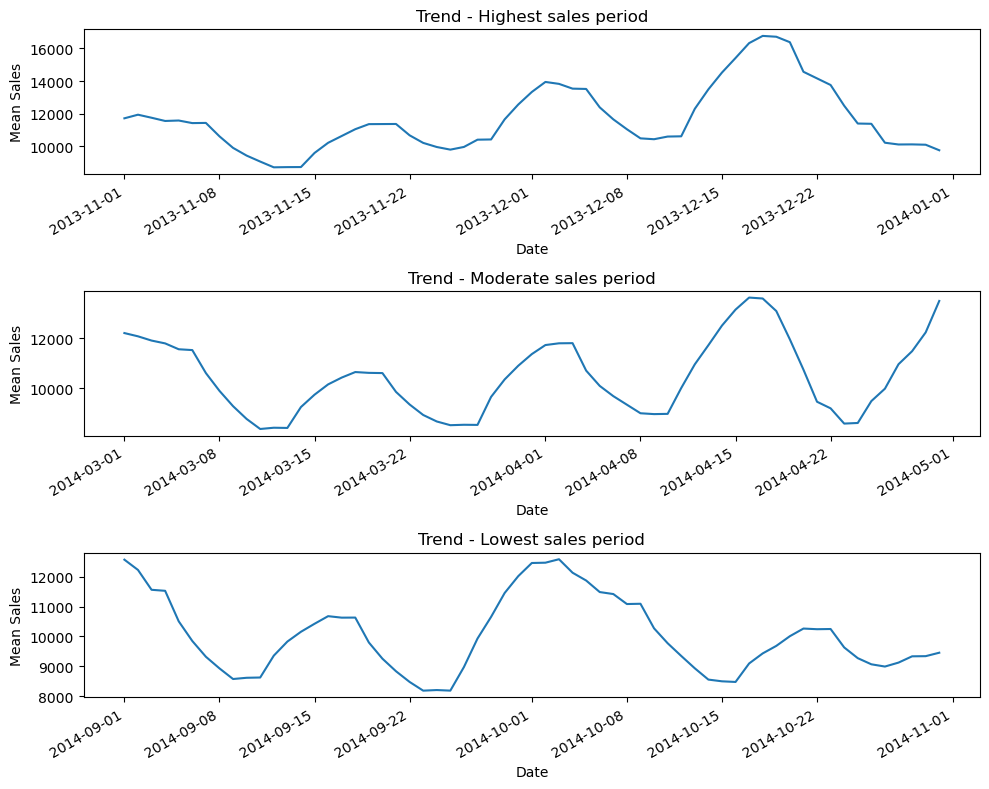

In [32]:
# sorting the df by date, only consider stores that were open
rm_timeseries = rm_imputed[~((rm_imputed['Open'] == 0))].sort_index()

# define a function to plot rolling mean for sales
def rolling_mean(df, start_date, end_date):
    """This function returns the rolling mean for the sales of a dataframe (df) in between
    the specified time interval (start_date to end_date)."""
    weekly = (
        df
        .loc[start_date:end_date, 'Sales']
        # get the rolling mean for sales weekly
        .rolling('7D', center=True)
        .mean()
    )
    return weekly

# initialise the figure and axes
fig, axes = plt.subplots(3, 1, figsize=(10,8))

daily_novDec13 = rolling_mean(rm_timeseries, pd.Timestamp("2013-11-01"), pd.Timestamp("2013-12-31"))
daily_novDec13.plot.line(ax=axes[0], title="Trend - Highest sales period", ylabel="Mean Sales")

daily_marApr14 = rolling_mean(rm_timeseries, pd.Timestamp("2014-03-01"), pd.Timestamp("2014-04-30"))
daily_marApr14.plot.line(ax=axes[1], title="Trend - Moderate sales period", ylabel="Mean Sales")

daily_sepOct14 = rolling_mean(rm_timeseries, pd.Timestamp("2014-09-01"), pd.Timestamp("2014-10-31"))
daily_sepOct14.plot.line(ax=axes[2], title="Trend - Lowest sales period", ylabel="Mean Sales")

fig.tight_layout();

- from first plot:
    - we can see that around a week before xmas, the sales on average are higher.
    - on xmas and xmas 2nd day, the turnover is low.
- from all plots:
    - similarities: observe that around every 15 days*, the sales rise, then slowly decrease.
      <br>*usually around mid-month until month-end, then the cycle repeats from beginning of new month to mid-month.
    
2. Let's investigate further on the effect of promotions, `Promo` and `Promo2` on our target `Sales`. We'll look at a more recent period of sales - year 2015.

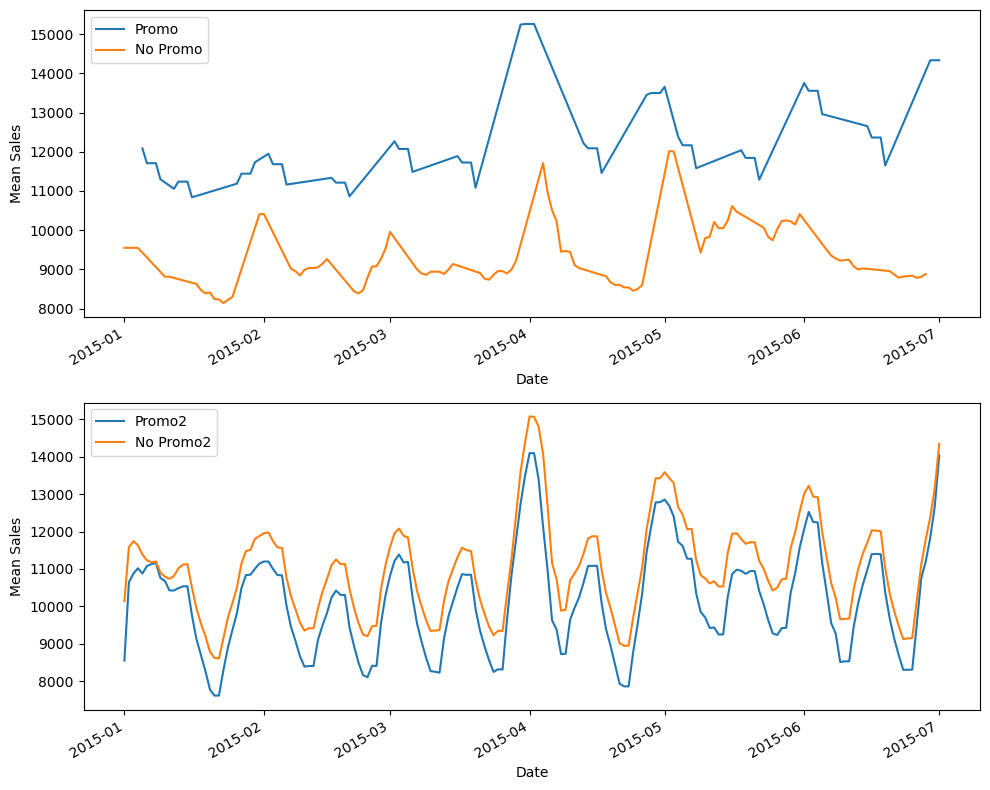

In [33]:
fig, axes = plt.subplots(2,1,figsize=(10,8))

# date interval we want to inspect
start = pd.Timestamp("2015-01-01")
end = pd.Timestamp("2015-07-01")

## Promo ##
rm_promo = rolling_mean(rm_timeseries[(rm_timeseries['Promo'] == 1)], start, end)
rm_noPromo = rolling_mean(rm_timeseries[(rm_timeseries['Promo'] == 0)], start, end)

rm_promo.plot.line(ylabel="Mean Sales", ax=axes[0])
rm_noPromo.plot.line(ylabel="Mean Sales", ax=axes[0])
axes[0].legend(['Promo','No Promo'])


## Promo2 ##
rm_promo2 = rolling_mean(rm_timeseries[(rm_timeseries['Promo2'] == 1)], start, end)
rm_noPromo2 = rolling_mean(rm_timeseries[(rm_timeseries['Promo2'] == 0)], start, end)

rm_promo2.plot.line(ylabel="Mean Sales", ax=axes[1])
rm_noPromo2.plot.line(ylabel="Mean Sales", ax=axes[1])
axes[1].legend(['Promo2','No Promo2'])


fig.tight_layout();

- `Promo` seems to have a noticeable positive effect on sales
- `Promo2` seems to have a slightly negative effect on sales

3. Investigating the sales differences between different store `Assortment` types

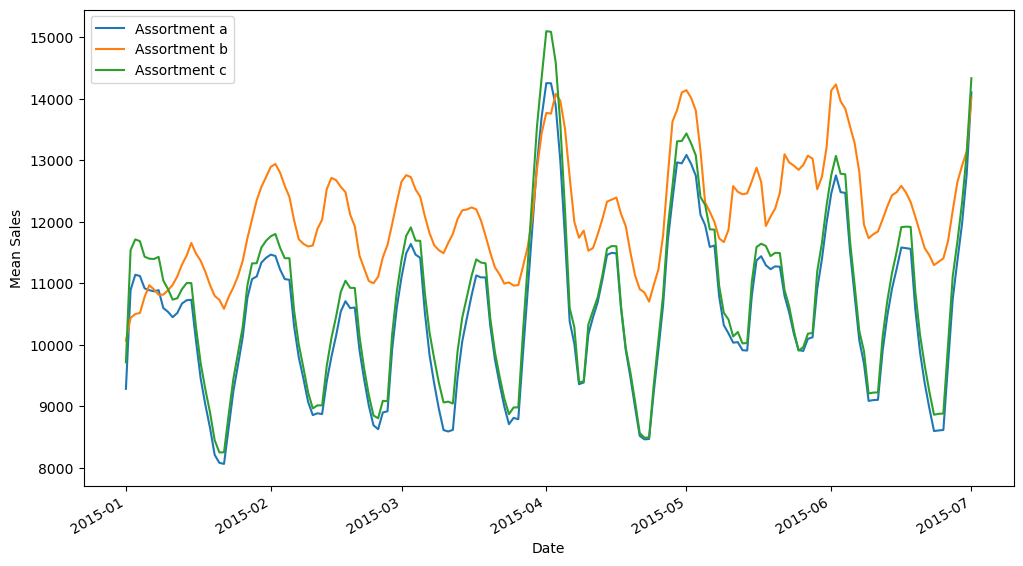

In [34]:
# date interval we want to inspect
start = pd.Timestamp("2015-01-01")
end = pd.Timestamp("2015-07-01")

# get the mean sales based on store assortment type
rm_assortment_a = rolling_mean(rm_timeseries[(rm_timeseries['Assortment'] == 'a')], start, end)
rm_assortment_b = rolling_mean(rm_timeseries[(rm_timeseries['Assortment'] == 'b')], start, end)
rm_assortment_c = rolling_mean(rm_timeseries[(rm_timeseries['Assortment'] == 'c')], start, end)

# plot
plt.figure(figsize=(12,7))
for df in [rm_assortment_a, rm_assortment_b, rm_assortment_c]:
    df.plot.line()
plt.ylabel("Mean Sales")
plt.legend(['Assortment a','Assortment b','Assortment c']);

- Generally, `Assortment = b (extra)` has higher mean sales than `Assortment = a (basic)` and `Assortment = c (extended)`
- `Assortment = c (extended)` has only slightly higher mean sales than `Assortment = a (basic)`

In [35]:
# for assortment c
# to see daily values - if run and analyse, can see that every 7 days (every sunday) the sales suddenly very high/low
# adjust the date as needed
# rm_timeseries[(rm_timeseries['Assortment'] == "c")].loc[pd.Timestamp("2015-01-01"):pd.Timestamp("2015-02-01"), 'Sales'].resample('1D').mean()

<br>

<hr style="border: 2px solid #83b076">

### V. Multivariate Linear Regression

$$
Sales_{pred} = \text{intercept} + c_{\text{store}} \times \text{Store} + ... + c_{\text{Weekday}} \times \text{Weekday}
$$


Setting up **MLR model**

- `Sales` is our **target variable**.
- Aim is to predict `Sales` from other variables.

Here, we look at first few values of variables first and its descriptive statistics.

In [36]:
rm_imputed.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StoreType,Assortment,Promo2Interval,StateHoliday,Promo2IntervalCat
Date,,,,,,,,,,,,,,,,,,
2015-07-31,4,620.0,9.0,2009.0,0,0,0,5,13995.0,1498,1,1,1,c,c,NA,0,0
2015-07-31,7,24000.0,4.0,2013.0,0,0,0,5,15344.0,1414,1,1,1,a,c,NA,0,0
2015-07-31,24,4590.0,3.0,2000.0,1,40,2011,5,14190.0,1082,1,1,1,a,c,"Jan,Apr,Jul,Oct",0,1
2015-07-31,25,430.0,4.0,2003.0,0,0,0,5,14180.0,1586,1,1,1,c,a,NA,0,0
2015-07-31,27,60.0,1.0,2005.0,1,5,2011,5,13213.0,1263,1,1,1,a,a,"Jan,Apr,Jul,Oct",0,1


In [37]:
rm_imputed.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Promo2IntervalCat
count,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000
mean,576.187603,5536.245997,6.923851,2009.099433,0.371789,9.450235,747.927657,3.998194,8805.227205,1009.707699,0.840115,0.381718,0.180458,0.557971
std,307.758776,9004.372374,3.208073,4.362555,0.483284,15.051344,972.221987,1.997380,5105.042705,690.499625,0.366501,0.485809,0.384569,0.859191
min,4.000000,40.000000,1.000000,1994.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,342.000000,400.000000,4.000000,2006.000000,0.000000,0.000000,0.000000,2.000000,6808.000000,682.000000,1.000000,0.000000,0.000000,0.000000
50%,560.000000,1870.000000,7.000000,2010.000000,0.000000,0.000000,0.000000,4.000000,9080.000000,970.000000,1.000000,0.000000,0.000000,0.000000
75%,827.000000,5980.000000,9.000000,2013.000000,1.000000,14.000000,2011.000000,6.000000,11556.000000,1300.000000,1.000000,1.000000,0.000000,1.000000
max,1114.000000,75860.000000,12.000000,2015.000000,1.000000,48.000000,2015.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,3.000000


Observations:

- `Store`, `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `AverageSales`, `Customers` are continuous numerical data.
- `Promo2`, `DayOfWeek`, `Open`, `Promo`, `StateHoliday`, and `SchoolHoliday` are categorical data.
- Here we try to include all variables into our MLR first, then do feature selection to filter out unnecessary variables.

For categorical data, we try to manipulate it so that we could include them in our MLR model.
- `Promo2`, `Open`, `Promo` and `SchoolHoliday` are binary which consist only `0` and `1`, so we don't need to manipulate it.
- `DayOfWeek` is not binomial categorial data. We could have an interval of between 1 to 7 determining the "day of week"
- `StoreType` is not binomial categorial data. We could have stores between type `A` to `D` that determine the type of store.
- Similarly for `Assortment`, `Promo2Interval`, `StateHoliday`, which are not binomial categorical data, too.
- For these non-binomial categorical data, we would use `dummies` method in `Pandas` that separate them into columns of each data, that only consist eiter `0` or `1`, indicating `False` or `True`.

In [38]:
# Initialise a function since we will be using it nultiple times
def create_dummies(df, column_name, rename_dict):
    dummies = (pd.get_dummies(df[column_name], dtype=int)
              .rename(columns=rename_dict)
              )
    return dummies

In [39]:
dummies_DayOfWeek = create_dummies(rm_imputed, 'DayOfWeek', {
                                    1: 'Monday', 
                                    2: 'Tuesday', 
                                    3: 'Wednesday', 
                                    4: 'Thursday', 
                                    5: 'Friday', 
                                    6: 'Saturday', 
                                    7: 'Sunday'})

dummies_Store_Type = create_dummies(rm_imputed, 'StoreType', {
                                    "a": "StoreTypeA", 
                                    "b": "StoreTypeB", 
                                    "c": "StoreTypeC",
                                    "d": "StoreTypeD"})

dummies_Assortment = create_dummies(rm_imputed, 'Assortment', {
                                    "a": "AssortmentA", 
                                    "b": "AssortmentB", 
                                    "c": "AssortmentC"})

dummies_Promo2Interval = (create_dummies(rm_imputed, 'Promo2Interval', {
                                        "Jan,Apr,Jul,Oct": "Promo2_Int_TypeA", 
                                        "Feb,May,Aug,Nov": "Promo2_Int_TypeB", 
                                        "Mar,Jun,Sept,Dec": "Promo2_Int_TypeC"})
                          .drop(columns=["NA"]))
                        # we doesn't need any of NA as 0 for these 3 cols could represent no promo dy

dummies_StateHoliday = (create_dummies(rm_imputed, 'StateHoliday', {
                                        "a": "PublicHoliday", 
                                        "b": "EasterHoliday", 
                                        "c": "Christmas"})
                            .drop(columns=['0',0])) 
                        # in the original dataset, both int(0), and str(0) are stored for indication of "no holiday"
                        # we doesn't need any of these as 0 for "a", "b", and "c" could represent a "no holiday" dy

Here we instantiate a df for MLR model that consist **all** manipulated columns in it. 

In [40]:
rm_mlr_df = (pd.concat([rm_imputed, dummies_DayOfWeek, dummies_Store_Type, dummies_Assortment, dummies_Promo2Interval, dummies_StateHoliday], axis=1)
             .drop(columns=["StoreType","DayOfWeek","Assortment","Promo2Interval","StateHoliday"]))

Navigating the correlations:

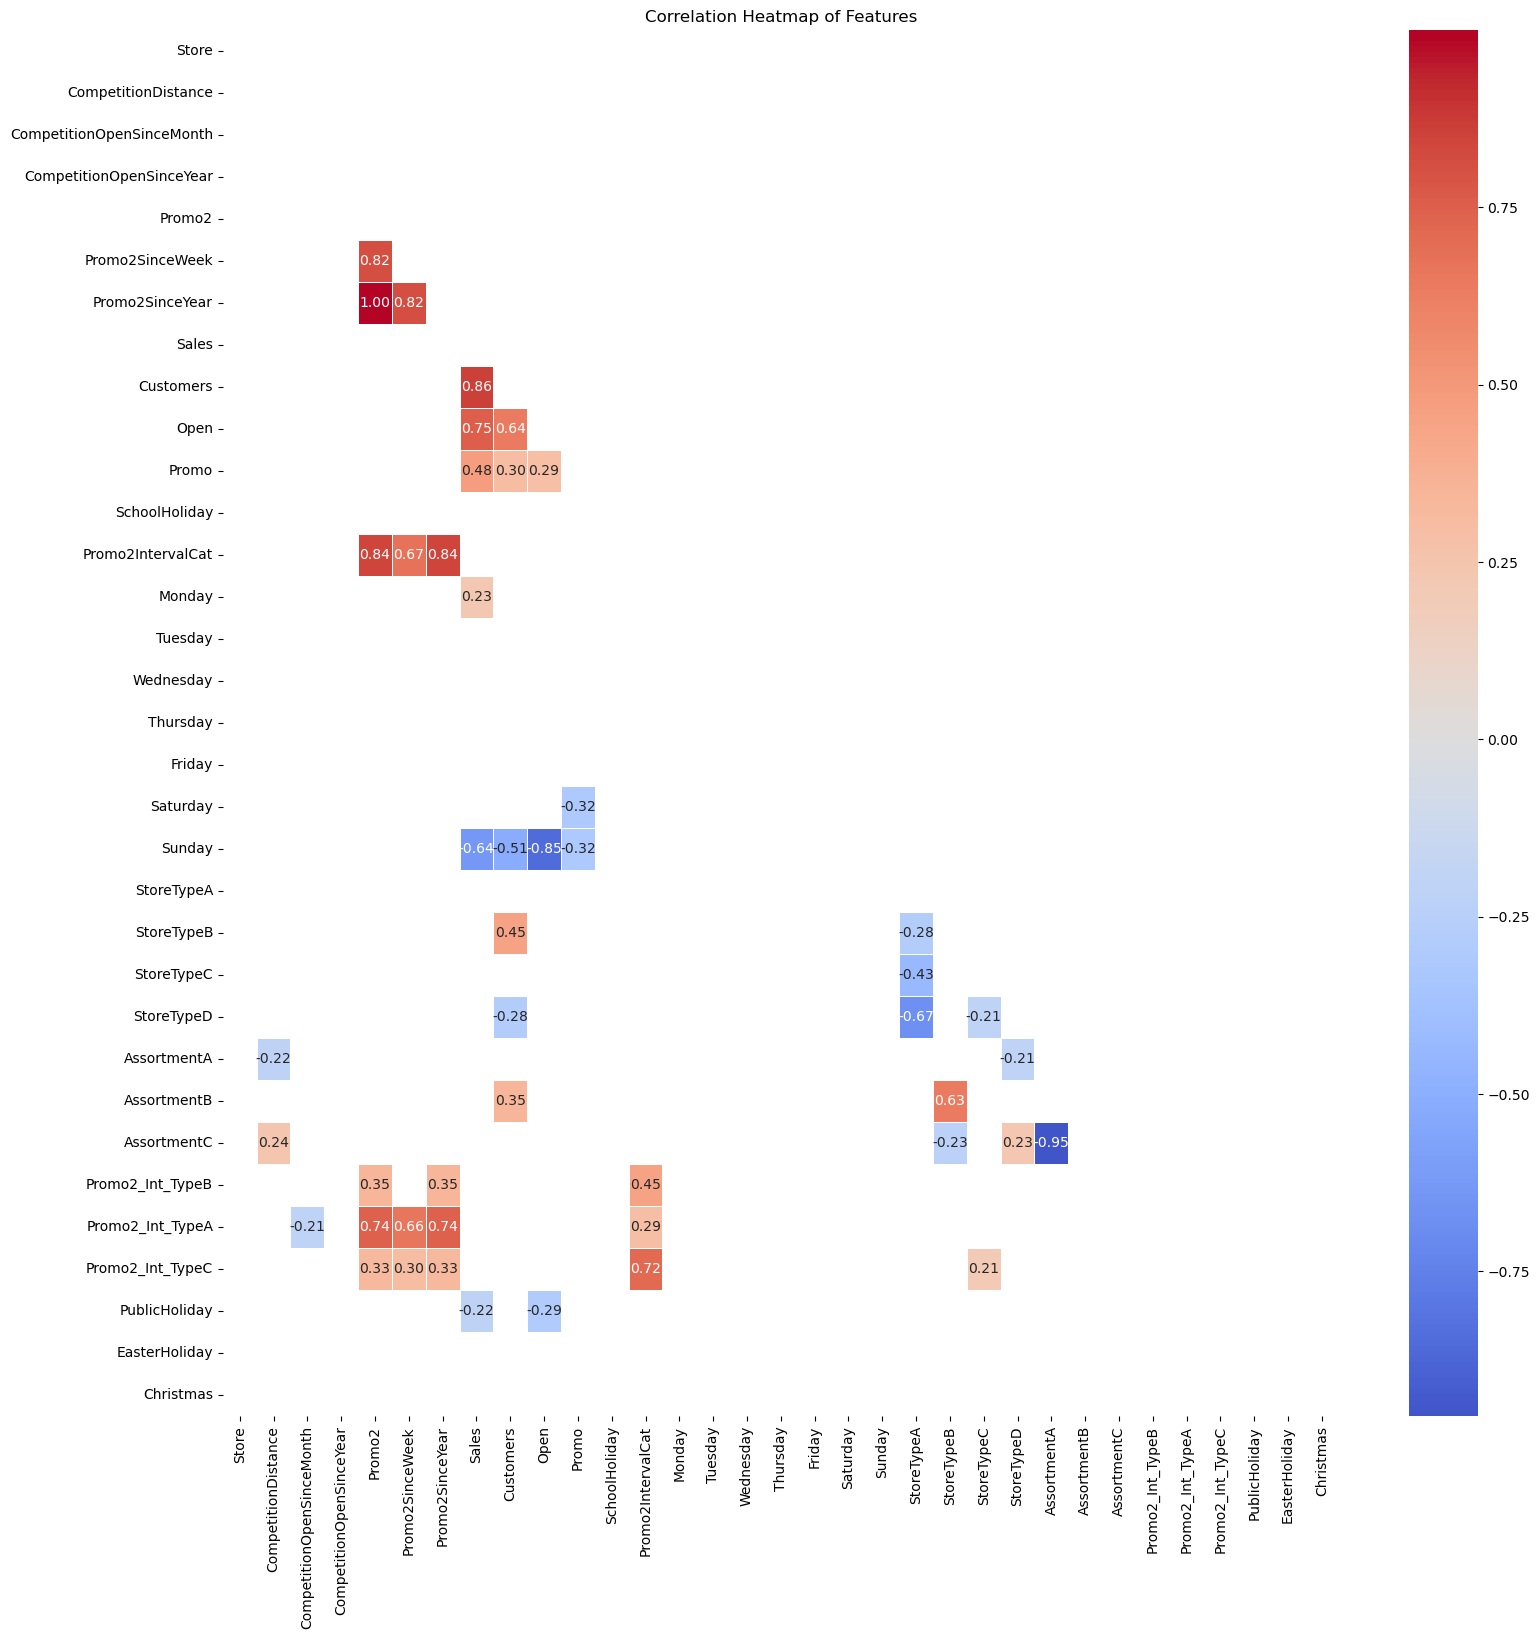

In [41]:
corrs = rm_mlr_df.corr()

# Filter out correlations lower than 0.3 by replacing them with NaN
filtered_corrs = corrs.where(np.abs(corrs) >= 0.2)
#filtered_corrs = corrs 

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_corrs, dtype=bool))

# Create the heatmap with the filtered correlations and mask
plt.figure(figsize=(18, 18))
sns.heatmap(filtered_corrs, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, cbar=True, mask=mask)

plt.title('Correlation Heatmap of Features')
plt.show()


Although this would cause a complex model, but as our first approach, we will still make a model directly using all variables and look at the result of accuracy.

In [42]:
def MLR_regression_training(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2,
    ) 
    # Construct and fit the model
    linear = LinearRegression() 
    linear.fit(X_train,Y_train)  

    # Evaluate model performance.
    training_predictions = linear.predict(X_train)  
    testing_predictions = linear.predict(X_test)    

    # Create a table of the various scores.
    table = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    
    return table

In [43]:
X = rm_mlr_df.drop(["Sales"],axis=1)
Y = rm_mlr_df['Sales']   
MLR_regression_training(X, Y)

,R^2,RMSE,MAE
train,0.909405,1538.078282,1114.278766
test,0.910960,1517.301474,1100.052622


According to the result above, the model seem to be overfitted much. This may because of this model is taking account in noise (e.g: assortment) rather than important variables. 

Thus, feature selections should be done.

**Feature selections**

We take in account of variables that have correlation (correlation > 0.4) to `sales`

The variables that fulfil the requirement are:
- `Promo`
- `Open`
- `Customers`

In [44]:
X = rm_mlr_df[["Promo","Open","Customers"]] 
Y = rm_mlr_df['Sales']   
MLR_regression_training(X, Y)

,R^2,RMSE,MAE
train,0.850031,1977.356949,1312.961026
test,0.845749,2003.345059,1325.739239


Ok we are cooked 🔥

Then now what else?

do again feature selection???? 

We have to see which of them are suitable, as there are slighly some correlation between each of them, that:
- `Promo` and `Open`: It could be have Promo if and only if it's open.
- `Open` and `Customers`: It could be have Customers if and only if it's open.
- `Promo` and `Customers`: Some customers might be coming if there is promo.

To further investigate the multicolinearity, we would use **lasso regression** as:
- Feature Selection is Important: 

In [45]:
# Calculate the absolute correlation with the target variable 'Sales'
correlations = abs(rm_mlr_df.corr()['Sales'])

# Select features with correlation >= 0.3 and drop 'Sales'
selected_features = (correlations[correlations > 0.2]
                     .index
                     .drop("Sales"))

# Define X and Y
X = rm_mlr_df[selected_features]  # Selecting the columns
y = rm_mlr_df['Sales']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Hyperparameter Tuning for Lasso
alphas = np.logspace(-4, 1, 50)
lasso_cv_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    lasso_cv_scores.append(np.mean(scores))

# Find the optimal alpha
optimal_alpha_lasso = alphas[np.argmax(lasso_cv_scores)]
print(f"Optimal alpha for Lasso: {optimal_alpha_lasso:.4f}")


Optimal alpha for Lasso: 0.0034


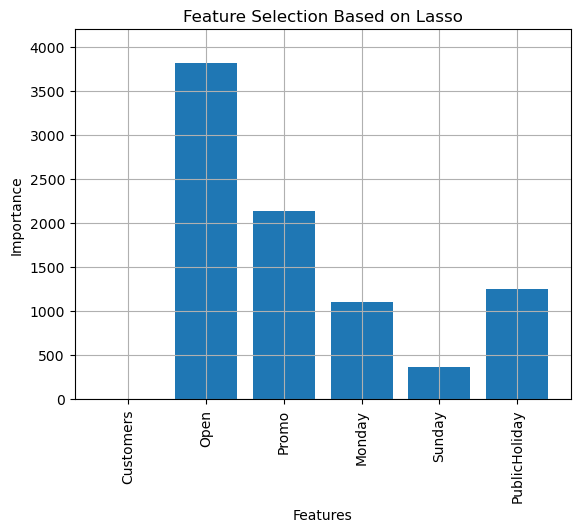

In [46]:
# Fit Lasso with the optimal alpha
lasso1 = Lasso(alpha=optimal_alpha_lasso)
lasso1.fit(X_train, y_train)

# Get feature names
names = X.columns  # This should be ["Promo", "Open", "Customers"]

# Get the absolute values of coefficients
lasso1_coef = np.abs(lasso1.coef_)

# Plotting
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, max(lasso1_coef)*1.1)
plt.show()

As both `Open` and `Promo` appeared to be the most important features here, we would choose both of them as out targeted variable, and further do normalisation。

In [47]:
rm_mlr_df = rm_mlr_df[["Open", "Promo", "Customers", "Sales"]]
X = rm_mlr_df.drop("Sales", axis = 1)
y = rm_mlr_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2,
    random_state=np.random.RandomState(31287)  # Keeps the 'random' split consistent.
) 

# Construct and fit the model
linear = LinearRegression()  # Instantatiate the linear regression model
linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.

# Evaluate model performance.
training_predictions = linear.predict(X_train)  # Get model predictions for both.
testing_predictions = linear.predict(X_test)    # training and testing data.

# Create a table of the various scores.
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, training_predictions),
        "test": r2_score(Y_test, testing_predictions)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions),
        "test": mean_absolute_error(Y_test, testing_predictions),
    },
})

,R^2,RMSE,MAE
train,0.849283,1981.597245,1314.785578
test,0.848756,1986.519776,1319.569546


In [49]:
feature_names = X.columns.tolist() # write the column names to a list

# create a Series for which the rows are the feature names and the data is 
# the regression coefficient values
coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)
coefficients

Open         4305.219638
Promo        2192.239000
Customers       4.445031
dtype: float64

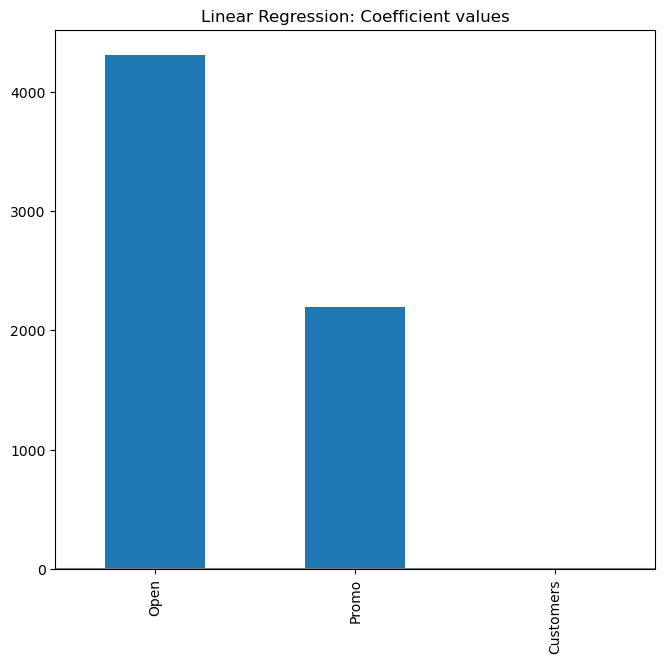

In [50]:
coefficients.plot(kind='bar', figsize=(10, 7)) 
plt.title('Linear Regression: Coefficient values') 
plt.axhline(y=0, color='.5') 
plt.subplots_adjust(left=.3) 

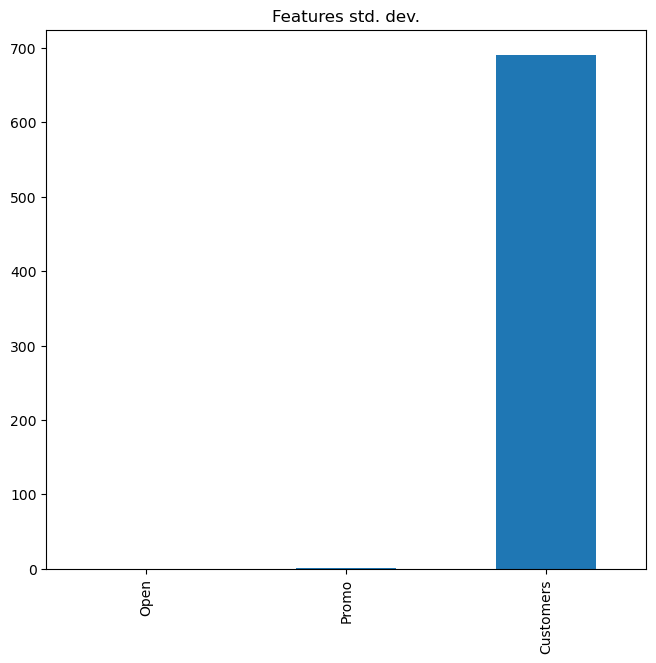

In [51]:
X_train.std(axis=0).plot(kind='bar', figsize=(10, 7)) 
plt.title('Features std. dev.') 
plt.subplots_adjust(left=.3)

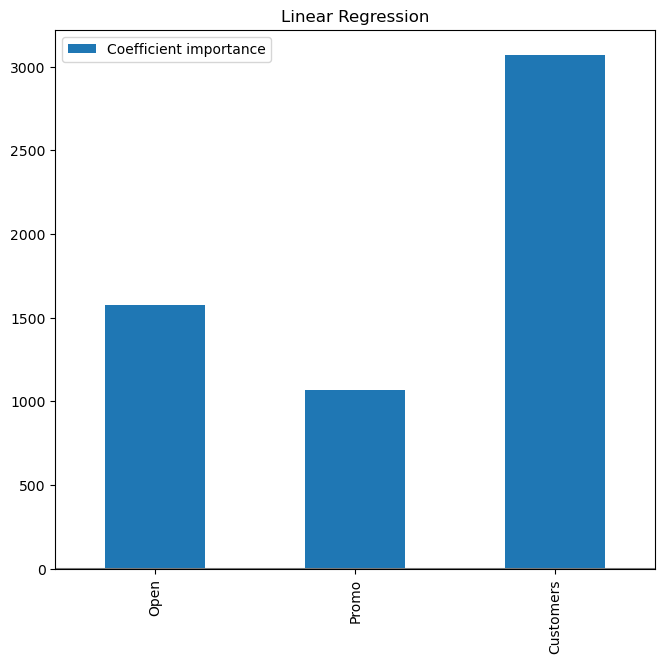

In [52]:
coefs = pd.DataFrame(
    linear.coef_ * X_train.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)
# do a similar plot of this variable, as above
coefs.plot(kind='bar', figsize=(10, 7))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

In [ ]:
nX =(X-X.mean())/X.std() # create nX, a normalised version of X
nX.describe() 

,Open,Promo,Customers
count,2.054660e+05,2.054660e+05,2.054660e+05
mean,6.667412e-17,-2.545236e-17,8.424178e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.292260e+00,-7.857360e-01,-1.462286e+00
25%,4.362485e-01,-7.857360e-01,-4.745950e-01
50%,4.362485e-01,-7.857360e-01,-5.750575e-02
75%,4.362485e-01,1.272686e+00,4.204091e-01
max,4.362485e-01,1.272686e+00,9.237213e+00


In [54]:
# substituting nX for X in train_test_split, to use our normalised data.

# Split into a training set with 80% of the data, and a testing set as the remainder.
X_train, X_test, Y_train, Y_test = train_test_split(
    nX, Y, test_size=0.2,
) 

# Construct and fit the model
linear = LinearRegression()  
linear.fit(X_train,Y_train)  

# Evaluate model performance.
training_predictions = linear.predict(X_train)  
testing_predictions = linear.predict(X_test)    

# Create a table of the various scores.
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, training_predictions),
        "test": r2_score(Y_test, testing_predictions)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions),
        "test": mean_absolute_error(Y_test, testing_predictions),
    },
})

,R^2,RMSE,MAE
train,0.849894,1976.124696,1311.266939
test,0.846310,2008.293858,1336.223998


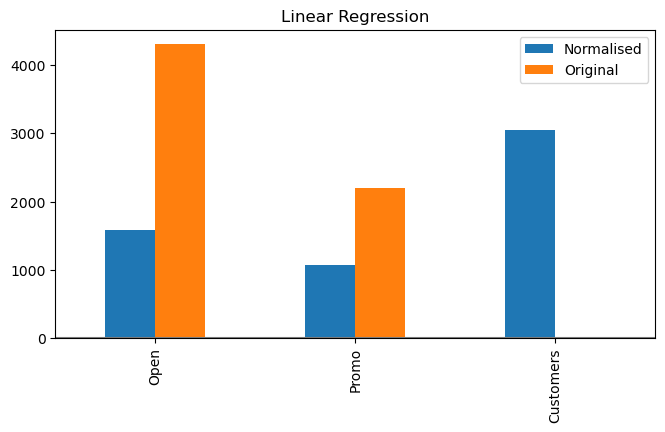

In [55]:
# create a new dataframe with the regression coefficients from the normalised data
normed_coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)

# add our original coefficient importance to this dataframe
all_coefficients = pd.DataFrame({
    'Normalised': normed_coefficients,
    'Original': coefficients,
})

# do a similar horizontal plot as before
ax = all_coefficients.plot(kind='bar',figsize=(10,4))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

In [56]:
feature_names = X.columns.tolist() # write the column names to a list

# create a Series for which the rows are the feature names and the data is 
# the regression coefficient values
coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)
coefficients

Open         1587.839023
Promo        1063.173671
Customers    3052.407757
dtype: float64

In [ ]:
MLR_regression_training(nX, Y)

,R^2,RMSE,MAE
train,0.849389,1982.163262,1315.226620
test,0.848323,1984.260348,1318.336232


Coefficients: [1581.78866832 1065.77154617 3062.65018144]
Intercept: 8807.128119247529
Mean Squared Error: 3886632.9372580973
R-squared: 0.8502958619986605
            Actual Price  Predicted Price
Date                                     
2014-01-31       18178.0     14387.192723
2014-10-07       11947.0     11591.155152
2014-07-23       11248.0     10279.991404
2013-09-20        7512.0      7973.571657
2013-05-24        7830.0      9082.427305
...                  ...              ...
2014-01-16        7614.0      8798.560259
2013-06-02           0.0      -134.649334
2013-11-29       12804.0      9916.286752
2013-02-01        9761.0      9876.367949
2014-04-16       17040.0     15294.733016

[61640 rows x 2 columns]


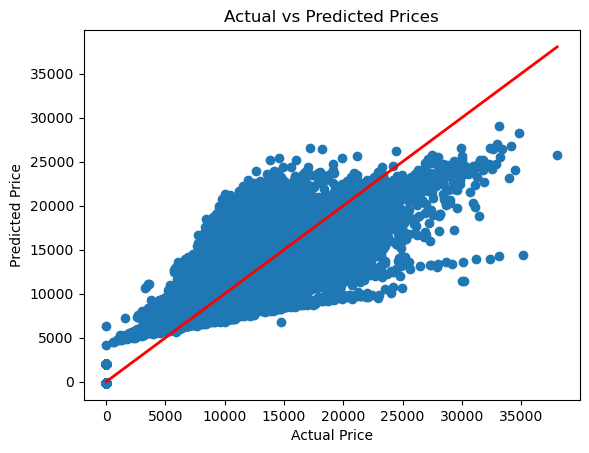

In [58]:
X = rm_mlr_df.drop(["Sales"],axis=1)
Y = rm_mlr_df['Sales']   

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the prices for the test set
y_pred = model.predict(X_test)

# Print the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Show the actual vs predicted prices
comparison = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
print(comparison)


# Plotting Actual vs Predicted Prices
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Perfect prediction line
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

<br>

<hr style="border: 2px solid #7ebdbf">

### VI. Predictive modelling

First, because our dataset is datetime-based, we have to manually define our training and testing sets to split on the most recent 4 weeks / the rest of the data.

In [59]:
# define training and testing sets, split between last 4 weeks of dataset and the rest of the data
rm_train = rm_imputed.loc[pd.Timestamp('2015-07-03'):,:]
rm_test = rm_imputed.loc[:pd.Timestamp('2015-07-04'),:]

X_train = rm_train[['Open','Promo','Customers']]
X_test = rm_test[['Open','Promo','Customers']]
y_train = rm_train['Sales']
y_test = rm_test['Sales']

Now we can proceed further with any predictive modelling, using the defined training and testing datasets.

<br>

<hr style="border: 1px solid #9fe1e3">

#### Regression Tree (Decision Tree Regressor)

Since our target and features are a mix of continuous and categorical variables, we will use decision tree based algorithms for our ML to predict the sales four weeks in advance (~ a month). We first try a single decision tree regression.

In [60]:
# instantiate the regression tree model
dtr = DecisionTreeRegressor(random_state=42)
# fit the model to the training set
rm_dtr = dtr.fit(X_train, y_train)

# calculate training scores
y_pred_train = rm_dtr.predict(X_train)
r2_train_dtr = r2_score(y_train, y_pred_train)

# calculate testing scores
y_pred_test = rm_dtr.predict(X_test)
r2_test_dtr = r2_score(y_test, y_pred_test)

# print out
print(f'Training score: {r2_train_dtr:.3}, Testing score: {r2_test_dtr:.3}')

Training score: 0.875, Testing score: 0.821


In [61]:
# obtain the depth with highest training accuracy determined by the model 
rm_dtr.tree_.max_depth

38

We obtain that the model-determined best depth of the DTR model is `max_depth=38`. However, is this really the case? From comparing the training and testing r2 scores, observe that the training score is quite high; the DTR model is **potentially overfitting**.

Thus, we try to calculate the training and testing r2 scores for different depths, and compare to obtain which depth value gives us the highest testing accuracy.

In [62]:
# create empty lists to store training and testing scores of the DTR model for each depth
r2_train_scores = []
r2_test_scores = []

# calculating scores for each depth between 1 to 40
for i in range(1,40):
    dtr = DecisionTreeRegressor(random_state=42, max_depth=i)
    rm_dtr = dtr.fit(X_train, y_train)
    
    y_pred_train = rm_dtr.predict(X_train)
    r2_train_dtr = r2_score(y_train, y_pred_train)
    r2_train_scores.append(r2_train_dtr)

    y_pred_test = rm_dtr.predict(X_test)
    r2_test_dtr = r2_score(y_test, y_pred_test)
    r2_test_scores.append(r2_test_dtr)

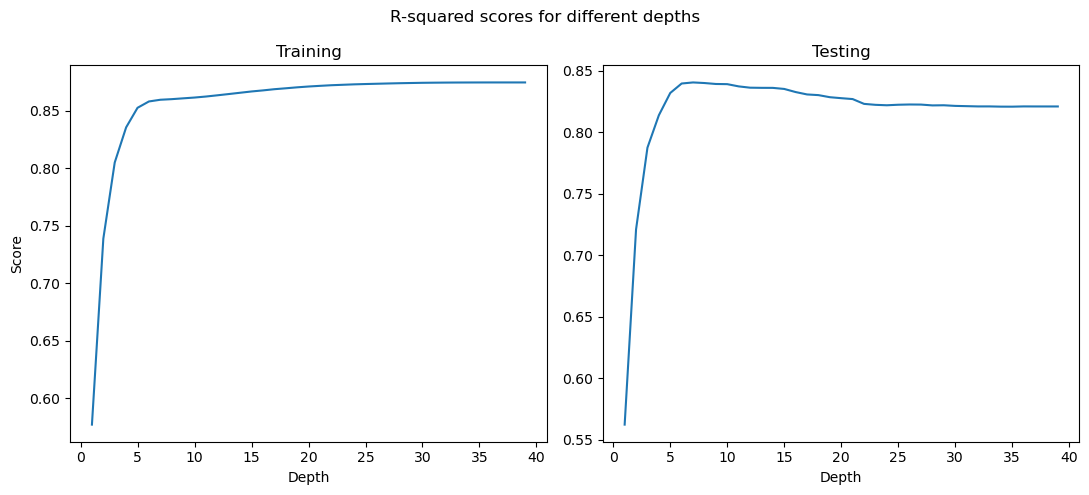

In [63]:
# initialise the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(11,5))

# add main title
plt.suptitle('R-squared scores for different depths')

# plot training scores against depth
ax[0].plot(list(range(1,40)), r2_train_scores)
ax[0].set_title('Training')
ax[0].set_xlabel('Depth')
ax[0].set_ylabel('Score')

# plot testing scores against depth
ax[1].plot(list(range(1,40)), r2_test_scores)
ax[1].set_title('Testing')
ax[1].set_xlabel('Depth')

plt.tight_layout();

From the above plots, observe that the depth value which gives highest testing r2 score is around 7. So we will model our data with DTR model of `max_depth=7`.

In [64]:
# instantiate the DTR model with max_depth=7
dtr = DecisionTreeRegressor(random_state=42, max_depth=7)
# fit the model to the training data
rm_dtr = dtr.fit(X_train, y_train)

# calculate training r2 scores
y_pred_train = rm_dtr.predict(X_train)
r2_train_dtr = r2_score(y_train, y_pred_train)

# calculate testing r2 scores
y_pred_test = rm_dtr.predict(X_test)
r2_test_dtr = r2_score(y_test, y_pred_test)

# print out
print(f'Training score: {r2_train_dtr:.3}, Testing score: {r2_test_dtr:.3}')

Training score: 0.86, Testing score: 0.84


Now, we can see the improvement in testing score. Further, the difference between training and testing scores have decreased; so the risk of overfitting has decreased. Overall, it seems the model is quite good at predicting the sales for the final four weeks based on previous data.

In [65]:
# if want to plot the tree out... but too many branch already, can't see anything hahaha
#plot_tree(rm_dtr, rounded = True, feature_names = X_train.columns.to_list());

Additionally, we can visualise the comparison between the actual vs. predicted values of sales for the most recent 4 weeks of the data.

In [66]:
# make the testing predictions array into a dataframe with appropriate index 
y_preds = pd.DataFrame(y_pred_test, index=y_test.index, columns=['PredictedSales'])

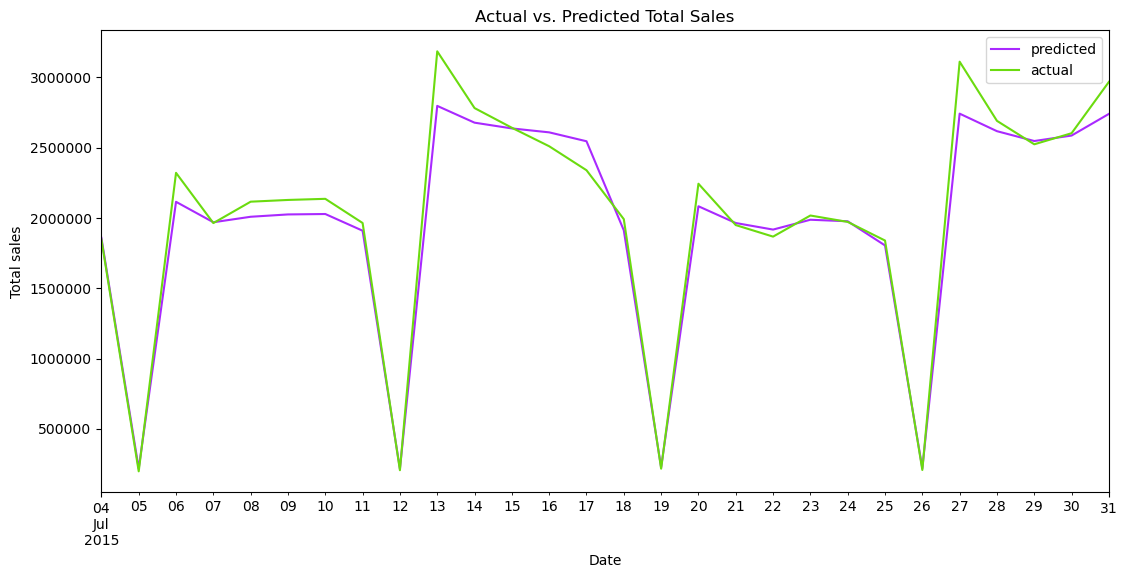

In [67]:
# line plots for total sales daily
(y_preds.resample('D').sum()).plot.line(figsize=(13, 6), color='#a929ff') # predicted
(y_test.resample('D').sum()).plot.line(figsize=(13, 6), color='#6bdb0f') # actual
plt.ticklabel_format(style='plain', axis='y')
plt.legend(['predicted','actual'])
plt.title('Actual vs. Predicted Total Sales')
plt.ylabel('Total sales');

#### Final DTR model summary

- DTR with `max_depth=7`
- Training score: **0.86**
- Testing score: **0.84**

<br>

<hr style="border: 1px solid #9fe1e3">

### Ensemble Learning

- `DecisionTreeRegressor` model is a single model that splits data based on feature values to make predictions tends to overfit. Hence, we need to perform ensemble learning.
- Ensemble learning combines the predictions of multiple models to create an ensemble (a group of models) while increasing predictions accuracy.
- In this case, we are examining:
   - Random Forest Regressor
   - Bagging (Bootstrap Aggregation)
   - Boosting
   - Stacking
   - Voting

<hr>

- First, we building a function to evaluate the **performance of model** on training data and testing data (the unseen data).

In [68]:
def evaluate_model(model):
    # Construct and fit the model
    model.fit(X_train,y_train)  

    # carry out cross validation
    subset_scores = cross_validate(
    model, X_train, y_train,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=np.random.RandomState(31287)),
    return_estimator=True,
)

    # Evaluate model performance.
    training_predictions = model.predict(X_train)  
    testing_predictions = model.predict(X_test)  
      
    # Create a table of the various scores.
    performance = pd.DataFrame({
        "R^2": {
            "train": r2_score(y_train, training_predictions),
            "test": r2_score(y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(y_train, training_predictions, squared=False),
            "test": mean_squared_error(y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(y_train, training_predictions),
            "test": mean_absolute_error(y_test, testing_predictions),
        },
    })
    return performance


##### Random Forest Regressor

combine multiple tree models to perform predictions.

- Initial `RandomForestRegressor` base model before **parameter tuning**

In [69]:
rfr = RandomForestRegressor(n_estimators=50,random_state=13).fit(X_train,y_train)
evaluate_model(rfr)

,R^2,RMSE,MAE
train,0.873691,1817.527410,1193.533433
test,0.825661,2004.980916,1277.651040


<hr>

**Hyperparameter tuning**

- First, we can do it computationaly by using the `RandomizedSearchCV` using `cross-validation`.
- Cross validation is always a better way then splitting the train-test data set manually to avoid **overfitting**.

In [157]:
# First, create a random grid for the parameters to be searched or tuned.

# number of iterations
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree 
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

**Your device might crash upon running this code (takes about 90 mins to run)** <br>
**Do not run the following code!!!**

In [159]:
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation then search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=13),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [160]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

- We can also investigate the most optimal value for the **n_estimators** which is the most important parameter in `RandomForestRegressor` through the naive approach, which is the **elbow method** by computing the mean-squared-error (MSE) agains n (number of iterations)

In [83]:
predictions = []
for tree in rfr.estimators_:
    predictions.append(tree.predict(X_train)[None, :])

predictions = np.vstack(predictions)
cum_mean = np.cumsum(predictions, axis=0) / np.arange(1, predictions.shape[0] + 1)[:, None]


mse_scores = []
for pred in cum_mean:
    mse_scores.append(mean_squared_error(y_train, pred))

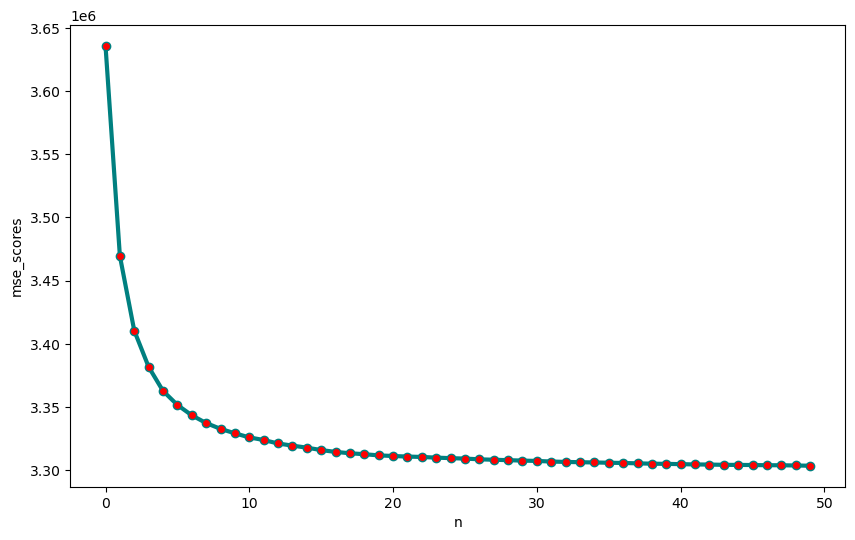

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(mse_scores, linewidth=3, color='teal',marker='o',markerfacecolor='red')
plt.xlabel('n')
plt.ylabel('mse_scores');

It seems when the n approaches infinity, the mse_score approaches 0. 

- The revised `RandomForestRegressor` model:

*The code below will take about 29 mins to run*

In [70]:

rfr_revised = RandomForestRegressor(n_estimators=1000, min_samples_split = 10,
                                    min_samples_leaf = 10, max_depth = 10
                                    ,max_features='sqrt',random_state=13).fit(X_train,y_train)
evaluate_model(rfr_revised)

,R^2,RMSE,MAE
train,0.862026,1899.599467,1230.237359
test,0.838858,1927.604685,1246.977878


- The model perform has improved by looking at the decreased difference of training and testing score, which indicates that the model is less overfit.

<hr>

Now we can plot the graph of comparison between predicted and actual sales for the last 4 weeks.

In [71]:
y_pred_rfr = rfr_revised.predict(X_test)
y_pred_rfr_df = pd.DataFrame(y_pred_rfr, index=y_test.index, columns=['PredictedSales'])

In [95]:
y_pred_rfr_df.resample('D').sum()

,PredictedSales
Date,
2015-07-04,1.856518e+06
2015-07-05,2.210024e+05
2015-07-06,2.112566e+06
2015-07-07,1.967344e+06
2015-07-08,2.007178e+06
2015-07-09,2.024823e+06
2015-07-10,2.035270e+06
2015-07-11,1.907712e+06
2015-07-12,2.145760e+05


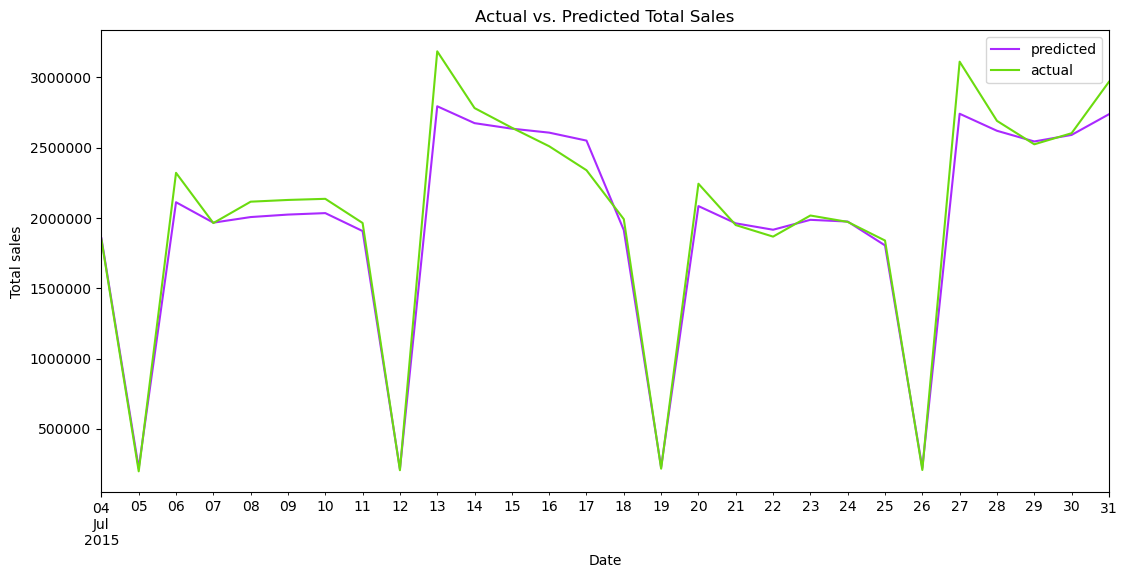

In [72]:
# line plots for total sales daily
(y_pred_rfr_df.resample('D').sum()).plot.line(figsize=(13, 6), color='#a929ff') # predicted
(y_test.resample('D').sum()).plot.line(figsize=(13, 6), color='#6bdb0f') # actual
plt.ticklabel_format(style='plain', axis='y')
plt.legend(['predicted','actual'])
plt.title('Actual vs. Predicted Total Sales')
plt.ylabel('Total sales');

##### Bagging (Bootstrap Aggregation)

bagging is used to reduce the variance of the decision tree

- We will perform hyperparameter tuning first for the `BaggingRegressor`

**Dont run the code!! (takes more than 1.5h)**

In [69]:
# Define the base estimator (DecisionTreeRegressor)
base_estimator = DecisionTreeRegressor(random_state=13)

# Set the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [10, 20, 50],  # Number of base estimators (Bagging)
    'max_samples': [0.5, 0.7, 1.0],  # Max samples for Bagging
    'max_features': [0.5, 0.7, 1.0],
    'estimator__max_depth': [None, 10, 20] # Max features for Bagging
}

# Initialize the BaggingRegressor with RandomForest as the base estimator
bagging_model = BaggingRegressor(estimator=base_estimator, random_state=13)

# Perform GridSearchCV on BaggingRegressor
grid_search_bagging = RandomizedSearchCV(estimator=bagging_model, param_distributions=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model with the training data
grid_search_bagging.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=BaggingRegressor(estimator=DecisionTreeRegressor(random_state=13),
                                              random_state=13),
                   n_jobs=-1,
                   param_distributions={'estimator__max_depth': [None, 10, 20],
                                        'max_features': [0.5, 0.7, 1.0],
                                        'max_samples': [0.5, 0.7, 1.0],
                                        'n_estimators': [10, 20, 50]},
                   scoring='neg_mean_squared_error')

In [148]:
grid_search_bagging.best_params_

{'n_estimators': 10,
 'max_samples': 0.5,
 'max_features': 1.0,
 'estimator__max_depth': 10}

In [149]:
# Get the best model
best_model = grid_search_bagging.best_estimator_
best_model


BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10, random_state=13),
                 max_samples=0.5, random_state=13)

In [150]:
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10,random_state=13), 
                                 n_estimators=10,max_samples=0.5,max_features=1.0, random_state=13)
evaluate_model(bagging_model)


,R^2,RMSE,MAE
train,0.861939,1900.201876,1231.795630
test,0.839208,1925.510839,1247.073879


In [70]:
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10,random_state=13), 
                                 n_estimators=10,max_samples=0.5,max_features=1.0, random_state=13)
bagging_model

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10, random_state=13),
                 max_samples=0.5, random_state=13)

- predictions

In [74]:
y_pred_bag = bagging_model.predict(X_test)
y_pred_bag_df = pd.DataFrame(y_pred_bag, index=y_test.index, columns=['PredictedSales'])

In [92]:
y_pred_bag_df.resample('D').sum()

,PredictedSales
Date,
2015-07-04,1.850637e+06
2015-07-05,2.243560e+05
2015-07-06,2.109191e+06
2015-07-07,1.967183e+06
2015-07-08,2.014487e+06
2015-07-09,2.036957e+06
2015-07-10,2.040465e+06
2015-07-11,1.904685e+06
2015-07-12,2.142061e+05


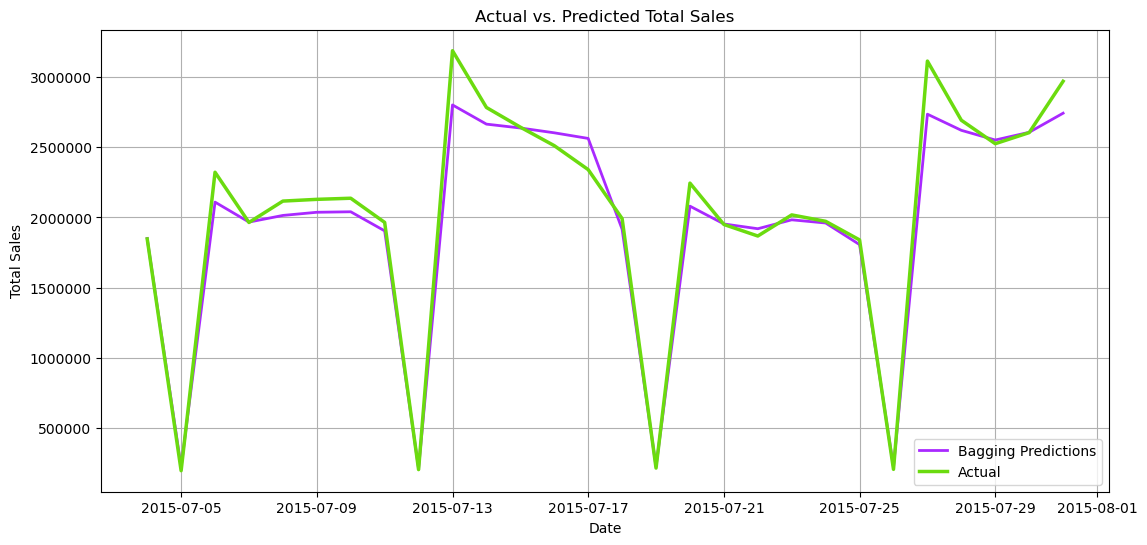

In [97]:
plt.figure(figsize=(13, 6))

# Predicted 
plt.plot(y_pred_bag_df.resample('D').sum(), color='#a929ff', label='Bagging Predictions', linewidth=2)
# Actual 
plt.plot(y_test.resample('D').sum(), color='#6bdb0f', label='Actual', linewidth=2.5)


plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc='lower right')  
plt.title('Actual vs. Predicted Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True);

##### Boosting

- We will perform **Adaptive Boosting (AdaBoost)** and **GradientBoost** to reduce the bias

**Note that we will not perform hyperparameter tuning anymore because its too computational expensive and took too long to run💀**

**AdaBoostRegressor**

*below code takes 8 mins to run*

In [75]:
# RandomForestRegressor as the base estimator
adaboost_model = AdaBoostRegressor(estimator=RandomForestRegressor(n_estimators=10, random_state=13), 
                                   n_estimators=50, random_state=13)

evaluate_model(adaboost_model)


,R^2,RMSE,MAE
train,0.856963,1934.141118,1304.425628
test,0.808898,2099.163930,1361.157406


In [157]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the base estimator
base_rf = DecisionTreeRegressor(random_state=13)

# Define the AdaBoost model using DecisionTree as the base estimator
adaboost_model = AdaBoostRegressor(estimator=base_rf, random_state=13)

# Define the parameter grid for tuning
param_grid_adaboost = {
    'n_estimators': [100, 200, 500],  # This is for AdaBoost, number of weak learners
    'learning_rate': [0.01, 0.1, 1],  # AdaBoost learning rate
    'loss': ['linear', 'square', 'exponential']  # Loss function for AdaBoost
}

# Perform RandomizedSearchCV
grid_search_adaboost = RandomizedSearchCV(estimator=adaboost_model, param_distributions=param_grid_adaboost, cv=5, 
                                          scoring='r2',n_iter=10, random_state=13)

# Fit the grid search model
grid_search_adaboost.fit(X_train, y_train)



RandomizedSearchCV(cv=5,
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(random_state=13),
                                               random_state=13),
                   param_distributions={'learning_rate': [0.01, 0.1, 1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [100, 200, 500]},
                   random_state=13, scoring='r2')

In [69]:
# RandomForestRegressor as the base estimator
adaboost_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10,random_state=13), 
                                   n_estimators=100, loss='linear',learning_rate=0.01,random_state=13)
evaluate_model(adaboost_model)


,R^2,RMSE,MAE
train,0.861033,1906.423430,1238.787319
test,0.840104,1920.135348,1246.718493


In [158]:
# Print the best parameters
print("Best Parameters:", grid_search_adaboost.best_params_)


Best Parameters: {'n_estimators': 100, 'loss': 'linear', 'learning_rate': 0.01}


**GradientBoostingRegressor**

In [70]:
gbr_model = GradientBoostingRegressor(random_state=13)
evaluate_model(gbr_model)

,R^2,RMSE,MAE
train,0.860193,1912.180619,1238.688555
test,0.839663,1922.780988,1246.671737


In [71]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for tuning
param_grid_gbr = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search_gbr = RandomizedSearchCV(estimator=gbr_model, param_distributions=param_grid_gbr, cv=5, scoring='r2')
grid_search_gbr.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=13),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.05],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 1000]},
                   scoring='r2')

In [72]:
# Print the best parameters
print("Best parameters for GradientBoostingRegressor:", grid_search_gbr.best_params_)


Best parameters for GradientBoostingRegressor: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 5, 'learning_rate': 0.05}


In [70]:
gbr_model = GradientBoostingRegressor(n_estimators= 100,min_samples_split=10,max_depth =5,learning_rate=0.05,random_state=13)

evaluate_model(gbr_model)

,R^2,RMSE,MAE
train,0.860339,1911.178702,1244.316960
test,0.839802,1921.948979,1251.552007


In [74]:
gbr_model.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=10,
                          random_state=13)

In [76]:
adaboost_model.fit(X_train,y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10,
                                                  random_state=13),
                  learning_rate=0.01, n_estimators=100, random_state=13)

**HistGradientBoostingRegressor**

`HistGradientBoostingRegressor` is a more advanced way and is more efficient for large data sets.

In [70]:
hgb_model = HistGradientBoostingRegressor(random_state=13,learning_rate=0.01,max_iter=100,min_samples_leaf = 50)
evaluate_model(hgb_model)

,R^2,RMSE,MAE
train,0.741946,2597.879940,1940.651088
test,0.722726,2528.526977,1865.553704


In [73]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Define the parameter grid for tuning
param_grid_hgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 500],
    'min_samples_leaf': [20, 50, 100],
    'max_depth': [None, 3, 5]
}

# Perform grid search
grid_search_hgb = RandomizedSearchCV(estimator=hgb_model, param_distributions=param_grid_hgb, cv=5, scoring='r2')
grid_search_hgb.fit(X_train, y_train)



RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingRegressor(learning_rate=0.01,
                                                           min_samples_leaf=50,
                                                           random_state=13),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [None, 3, 5],
                                        'max_iter': [100, 200, 500],
                                        'min_samples_leaf': [20, 50, 100]},
                   scoring='r2')

In [74]:

# Print the best parameters
print("Best parameters for HistGradientBoostingRegressor:", grid_search_hgb.best_params_)

Best parameters for HistGradientBoostingRegressor: {'min_samples_leaf': 50, 'max_iter': 500, 'max_depth': 5, 'learning_rate': 0.05}


In [79]:
hgb_model = HistGradientBoostingRegressor(random_state=13,learning_rate=0.05,max_iter=500,min_samples_leaf = 50)
evaluate_model(hgb_model)

,R^2,RMSE,MAE
train,0.857752,1928.797622,1243.596359
test,0.837598,1935.123993,1249.317690


**XGBRegressor**

`XGBoost` is a more advanced way than `GradientBoosting` as it a more extreme version compared to the gradient boosting algorithm <br>
XGBoost is actually the regularized form of the gradient boosting algorithm and often perform better.

*Below code takes abt 20 mins to run*

In [86]:
xgb_model = XGBRegressor(random_state=13)
evaluate_model(xgb_model)

,R^2,RMSE,MAE
train,0.858115,1926.335406,1241.975167
test,0.836981,1938.794361,1251.251869


In [70]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from xgboost import XGBRegressor 

# Randomized search for XGBRegressor
param_dist_xgb = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': [3, 5, 7],
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb, 
                                       n_iter=50, cv=5, scoring='r2', random_state=13)

random_search_xgb.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CACD6DA6F0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CACD6638C0>,
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CACD6D9040>},
                   random_state=13, scoring='r2')

In [71]:
print("Best parameters for XGBRegressor (RandomizedSearchCV):", random_search_xgb.best_params_)


Best parameters for XGBRegressor (RandomizedSearchCV): {'colsample_bytree': 0.9089515038722232, 'learning_rate': 0.03037524903832435, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8502105567991318}


In [71]:
xgb_model = XGBRegressor(learning_rate = 0.03037524903832435,max_depth = 5,n_estimators = 500, random_state=13)

evaluate_model(xgb_model) 

,R^2,RMSE,MAE
train,0.858059,1926.718206,1242.299949
test,0.837085,1938.179506,1250.502755


In [79]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03037524903832435,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=13, ...)

In [70]:
# Required imports
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from scipy.stats import uniform
import numpy as np


# Initialize XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=13)

# Parameter distributions for RandomizedSearchCV
param_dist_xgb = {
    'n_estimators': [100, 500, 1000],                     # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),                  # Learning rate
    'max_depth': [3, 5, 7],                               # Maximum depth of trees
    'subsample': uniform(0.6, 0.4),                       # Subsample ratio of training instances
    'colsample_bytree': uniform(0.6, 0.4),                # Subsample ratio of columns for each tree
    'gamma': uniform(0, 0.5),                             # Minimum loss reduction to make a split
    'min_child_weight': [1, 3, 5]                         # Minimum sum of instance weight (Hessian) in a child
}

# Perform randomized search with cross-validation
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist_xgb, 
    n_iter=50,                  # Number of parameter settings sampled
    cv=5,                       # 5-fold cross-validation
    scoring='r2',               # R² scoring
    random_state=13,            # For reproducibility
    verbose=2,                  # Output verbosity for tracking progress
    n_jobs=-1                   # Use all available cores for parallel processing
)

# Fit the randomized search
random_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001578453D220>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000015794E9FC50>,
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000157845709B0>},
                   random_state=13, scoring='r2', verbose=2)

In [71]:
# Retrieve the best hyperparameters
best_params = random_search_xgb.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': 0.9476755692791033, 'gamma': 0.42526872812040056, 'learning_rate': 0.014436020592862633, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.6127971777839517}


In [74]:
xgb_model_tuned = XGBRegressor(colsample_bytree =0.9476755692791033,learning_rate = 0.034436020592862633,max_depth = 5,n_estimators = 500,
                          gamma = 0.42526872812040056, min_child_weight = 5,  
                          subsample = 0.6127971777839517, random_state=13)
evaluate_model(xgb_model_tuned) 

,R^2,RMSE,MAE
train,0.858010,1927.048599,1242.506822
test,0.837107,1938.046690,1250.407161


- predictions

In [87]:
# AdaBoost
y_pred_ada = adaboost_model.predict(X_test)
y_pred_ada_df = pd.DataFrame(y_pred_ada, index=y_test.index, columns=['PredictedSales-ADA'])

# GradientBoost
y_pred_gbr= gbr_model.predict(X_test)
y_pred_gbr_df = pd.DataFrame(y_pred_gbr, index=y_test.index, columns=['PredictedSales-GBR'])

# HistGradientBoost
y_pred_hgb = hgb_model.predict(X_test)
y_pred_hgb_df = pd.DataFrame(y_pred_hgb, index=y_test.index, columns=['PredictedSales-HBR'])

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_df = pd.DataFrame(y_pred_xgb, index=y_test.index, columns=['PredictedSales-XGB'])


##### predictions df

In [74]:
y_pred_ada_df.resample('D').sum()

,PredictedSales-ADA
Date,
2015-07-04,1.861138e+06
2015-07-05,2.199514e+05
2015-07-06,2.122607e+06
2015-07-07,1.972861e+06
2015-07-08,2.013286e+06
2015-07-09,2.031898e+06
2015-07-10,2.041708e+06
2015-07-11,1.912452e+06
2015-07-12,2.162165e+05


In [75]:
y_pred_gbr_df.resample('D').sum()

,PredictedSales-GBR
Date,
2015-07-04,1.858597e+06
2015-07-05,2.297858e+05
2015-07-06,2.114409e+06
2015-07-07,1.968196e+06
2015-07-08,2.007612e+06
2015-07-09,2.023245e+06
2015-07-10,2.033342e+06
2015-07-11,1.909354e+06
2015-07-12,2.258045e+05


In [82]:
y_pred_hgb_df.resample('D').sum()

,PredictedSales-HBR
Date,
2015-07-04,1.855890e+06
2015-07-05,2.149114e+05
2015-07-06,2.116107e+06
2015-07-07,1.968805e+06
2015-07-08,2.006681e+06
2015-07-09,2.025493e+06
2015-07-10,2.036132e+06
2015-07-11,1.912315e+06
2015-07-12,2.106178e+05


In [76]:
y_pred_xgb_df.resample('D').sum()

,PredictedSales-XGB
Date,
2015-07-04,1.858407e+06
2015-07-05,2.137011e+05
2015-07-06,2.113401e+06
2015-07-07,1.968812e+06
2015-07-08,2.006743e+06
2015-07-09,2.022963e+06
2015-07-10,2.035032e+06
2015-07-11,1.912287e+06
2015-07-12,2.095894e+05


In [77]:
y_test.resample('D').sum()

Date
2015-07-04    1847362.0
2015-07-05     198421.0
2015-07-06    2321712.0
2015-07-07    1964393.0
2015-07-08    2116547.0
2015-07-09    2128904.0
2015-07-10    2136844.0
2015-07-11    1964917.0
2015-07-12     206285.0
2015-07-13    3186179.0
2015-07-14    2782495.0
2015-07-15    2642414.0
2015-07-16    2510839.0
2015-07-17    2340296.0
2015-07-18    1992084.0
2015-07-19     217232.0
2015-07-20    2244268.0
2015-07-21    1950103.0
2015-07-22    1868059.0
2015-07-23    2018215.0
2015-07-24    1972662.0
2015-07-25    1840213.0
2015-07-26     208047.0
2015-07-27    3112457.0
2015-07-28    2691537.0
2015-07-29    2524770.0
2015-07-30    2603594.0
2015-07-31    2968844.0
Freq: D, Name: Sales, dtype: float64

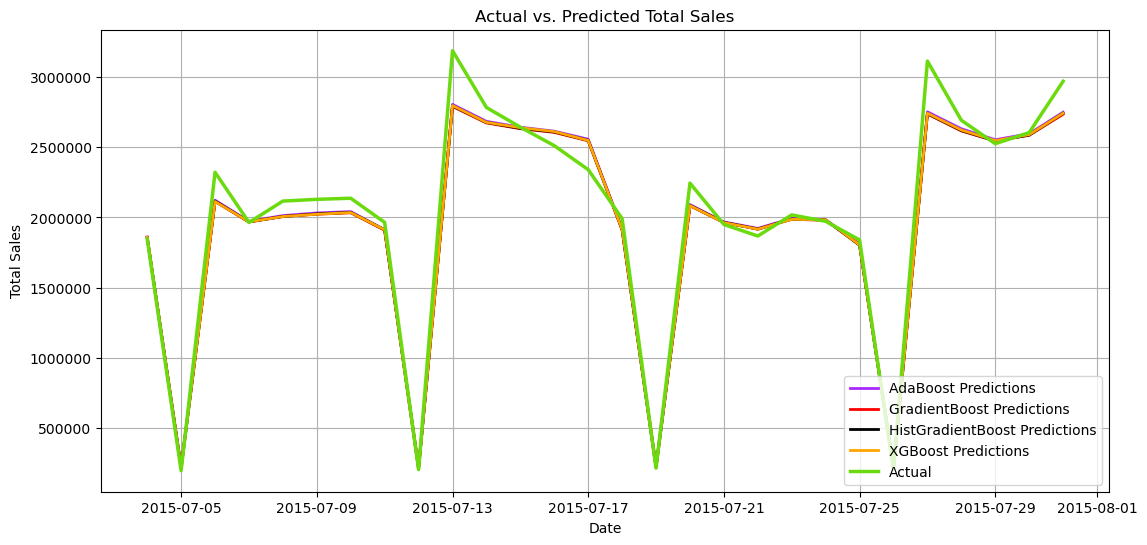

In [85]:
plt.figure(figsize=(13, 6))

# Predicted 
plt.plot(y_pred_ada_df.resample('D').sum(), color='#a929ff', label='AdaBoost Predictions', linewidth=2)
plt.plot(y_pred_gbr_df.resample('D').sum(), color='red', label='GradientBoost Predictions', linewidth=2)
plt.plot(y_pred_hgb_df.resample('D').sum(), color='black', label='HistGradientBoost Predictions', linewidth=2)
plt.plot(y_pred_xgb_df.resample('D').sum(), color='orange', label='XGBoost Predictions', linewidth=2)
#plt.plot(y_pred_stack_df.resample('D').sum(), color='blue', label='Stacking Predictions', linewidth=2)
#plt.plot(y_pred_vote_df.resample('D').sum(), color='teal', label='Voting Predictions', linewidth=2)

# Actual 
plt.plot(y_test.resample('D').sum(), color='#6bdb0f', label='Actual', linewidth=2.5)


plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc='lower right')  
plt.title('Actual vs. Predicted Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True);

#### Stacking

*below code takes about 100 mins to run*

In [75]:
# base model
estimators = [
    ('rf', GradientBoostingRegressor(n_estimators= 100,min_samples_split=10,max_depth =5,learning_rate=0.05,random_state=13)),
    ('hgb', HistGradientBoostingRegressor(random_state=13,learning_rate=0.05,max_iter=500,min_samples_leaf = 50)),
    ('xgb',XGBRegressor(colsample_bytree =0.9476755692791033,learning_rate = 0.034436020592862633,max_depth = 5,n_estimators = 500,
                          gamma = 0.42526872812040056, min_child_weight = 5,  
                          subsample = 0.6127971777839517, random_state=13))
]

# Define the stacking regressor with a meta-model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3))

# Evaluate the Stacking Regressor
evaluate_model(stacking_model)


,R^2,RMSE,MAE
train,0.860349,1911.110389,1236.518341
test,0.839814,1921.876532,1244.695618


In [76]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Define the base model to be stacked
estimators = [
    ('rf', GradientBoostingRegressor(n_estimators=300, min_samples_split=20, max_depth=4, learning_rate=0.01, random_state=13)),
    ('rfr', RandomForestRegressor(n_estimators=1000, min_samples_split = 10,
                                    min_samples_leaf = 10, max_depth = 10
                                    ,max_features='sqrt',random_state=13)),
    ('xgb', XGBRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300,
                         gamma=0.5, min_child_weight=6, subsample=0.7, random_state=13))
]


# Stacking regressor with regularized meta-model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5))
evaluate_model(stacking_model)

,R^2,RMSE,MAE
train,0.859846,1914.549783,1237.765094
test,0.840016,1920.664010,1242.543162


##### Voting

- hard voting (prediction with most vote wins)

*below code takes abt 8 mins to run*

In [80]:
# base model
voting_estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=13)),
    ('gbr', GradientBoostingRegressor(random_state=13)),
    ('hgr',HistGradientBoostingRegressor(random_state=13)),
    ('dtr', DecisionTreeRegressor(random_state=13))
]

# Voting Regressor (hard voting)
voting_model = VotingRegressor(estimators=voting_estimators)

# Evaluate 
evaluate_model(voting_model)

,R^2,RMSE,MAE
train,0.870404,1841.022674,1205.943667
test,0.834792,1951.768204,1256.444358


- predictions

In [77]:
# Stacking
y_pred_stack = stacking_model.predict(X_test)
y_pred_stack_df = pd.DataFrame(y_pred_stack, index=y_test.index, columns=['PredictedSales-ADA'])

# Voting
#y_pred_vote= voting_model.predict(X_test)
#y_pred_vote_df = pd.DataFrame(y_pred_vote, index=y_test.index, columns=['PredictedSales-GBR'])


<hr>

Overall Visualization

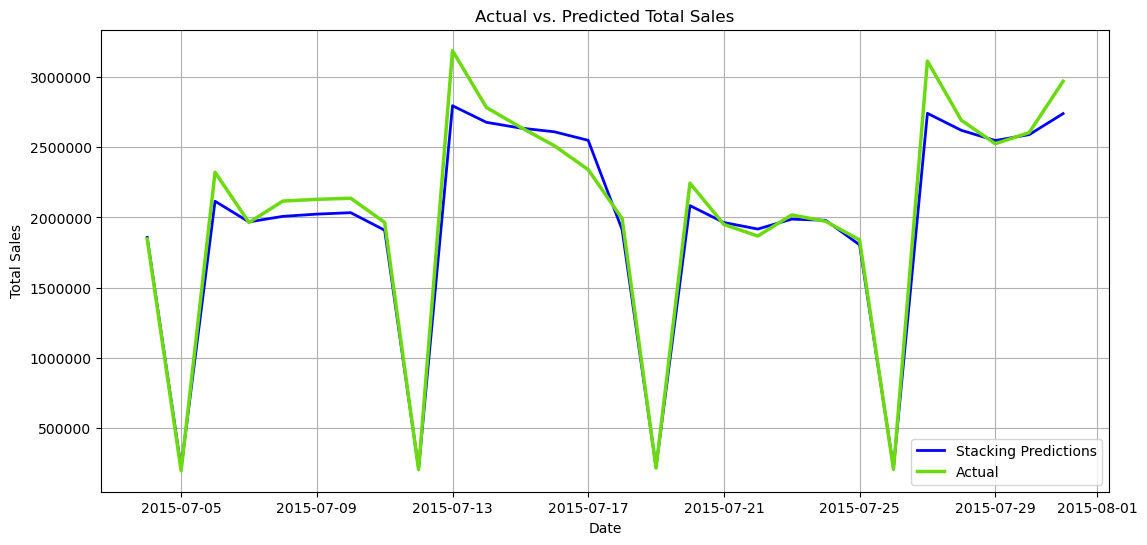

In [79]:
plt.figure(figsize=(13, 6))
plt.plot(y_pred_stack_df.resample('D').sum(), color='blue', label='Stacking Predictions', linewidth=2)
plt.plot(y_test.resample('D').sum(), color='#6bdb0f', label='Actual', linewidth=2.5)
plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc='lower right')  
plt.title('Actual vs. Predicted Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True);


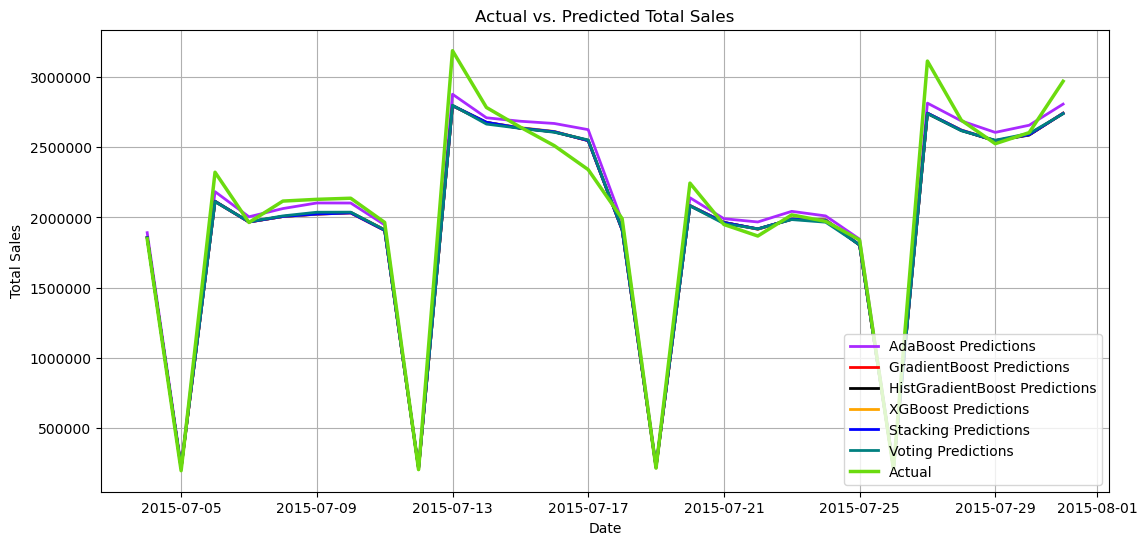

In [131]:
plt.figure(figsize=(13, 6))

# Predicted 
plt.plot(y_pred_ada_df.resample('D').sum(), color='#a929ff', label='AdaBoost Predictions', linewidth=2)
plt.plot(y_pred_gbr_df.resample('D').sum(), color='red', label='GradientBoost Predictions', linewidth=2)
plt.plot(y_pred_hgb_df.resample('D').sum(), color='black', label='HistGradientBoost Predictions', linewidth=2)
plt.plot(y_pred_xgb_df.resample('D').sum(), color='orange', label='XGBoost Predictions', linewidth=2)
plt.plot(y_pred_stack_df.resample('D').sum(), color='blue', label='Stacking Predictions', linewidth=2)
plt.plot(y_pred_vote_df.resample('D').sum(), color='teal', label='Voting Predictions', linewidth=2)

# Actual 
plt.plot(y_test.resample('D').sum(), color='#6bdb0f', label='Actual', linewidth=2.5)


plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc='lower right')  
plt.title('Actual vs. Predicted Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True);


The best model is _________
<br>

The **AdaBoost model / Stacking model** follows the line of trend of the actual sales better.

